# 1 - Import Libraries

In [418]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

# 2 - Import Data

In [419]:
df = pd.read_csv("ML_cardio_dataSet_final.csv")

# 3 - Inspect Data

## 3.1 - Data

In [420]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,4,17474,f,156,56.0,100,60,1,1,0,0,0,0
2,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
3,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
4,13,17668,1,158,71.0,110,70,1,1,0,0,1,0


In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64511 entries, 0 to 64510
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           64511 non-null  int64  
 1   age          64511 non-null  int64  
 2   gender       64511 non-null  object 
 3   height       64511 non-null  int64  
 4   weight       64511 non-null  float64
 5   ap_hi        64511 non-null  int64  
 6   ap_lo        64511 non-null  int64  
 7   cholesterol  64511 non-null  int64  
 8   gluc         64511 non-null  int64  
 9   smoke        64511 non-null  int64  
 10  alco         64511 non-null  int64  
 11  active       64511 non-null  int64  
 12  cardio       64511 non-null  int64  
dtypes: float64(1), int64(11), object(1)
memory usage: 6.4+ MB


In [422]:
df.memory_usage(index=True).sum() / 1000000

6.709276

## 3.2 - Statistics

In [423]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [424]:
df.describe()

,id,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000
mean,53562.084482,19420.396847,164.364651,73.977297,128.201144,95.240796,1.353955,1.222768,0.088419,0.053898,0.805258,0.457116
std,27150.759446,2473.001103,8.215813,14.303907,153.850257,179.103902,0.669552,0.568043,0.283906,0.225818,0.396005,0.498161
min,0.000000,10798.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30880.500000,17605.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53891.000000,19673.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,76850.500000,21290.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,207.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

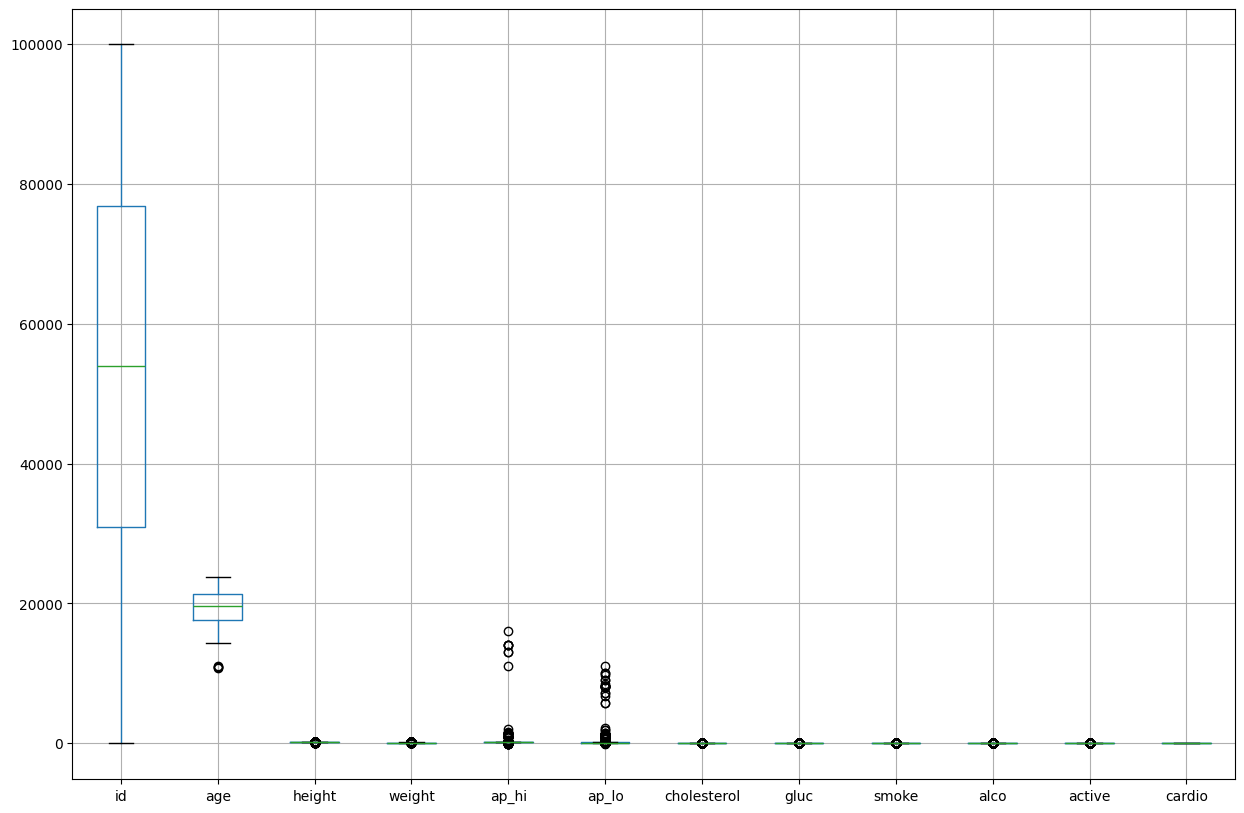

In [425]:
df.boxplot(figsize=(15, 10))

# 4 - Data Cleaning

## 4.1 - Remove redundant ID column

In [426]:
df.drop(columns=['id'], inplace=True)

## 4.2 Age column unit conversion

Convert unit of years from days to years, rounded as integers

In [427]:
df['age'] = (df['age'] / 365).round().astype('int')

## 4.3 - Gender column

This column needs to contain '1' for female, '2' for male. At the moment, there are a few non-standardised values such as 'm', 'f', 'MALE', and 'FEMALE'.

In [428]:
df['gender'].unique()

array(['2', 'f', '1', 'F', 'm', 'MALE', 'FEMALE'], dtype=object)

In [429]:
df['gender'].replace('f', '1', inplace=True)
df['gender'].replace('F', '1', inplace=True)
df['gender'].replace('FEMALE', '1', inplace=True)
df['gender'].replace('m', '2', inplace=True)
df['gender'].replace('MALE', '2', inplace=True)

df["gender"] = pd.to_numeric(df["gender"])

In [430]:
df['gender'].unique()

array([2, 1])

## 4.4 - Blood pressure columns

Systolic is the higher blood pressure recording compared to diastolic, it shouldn't be possible to have instances the other way around. Furthermore, it is not possible to have negative blood pressure readings.

In [431]:
print("Diastolic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

Diastolic pressure is higher than systolic one in 1074 cases


In [432]:
df = df[df['ap_lo']>=0]
df = df[df['ap_hi']>=0]

In [433]:
df = df[df['ap_hi'] > df['ap_lo']].reset_index(drop=True)

In [434]:
print("Diastolic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

Diastolic pressure is higher than systolic one in 0 cases


## 4.5 - Handling outliers

### 4.5.1 - Height and weight columns

<Axes: >

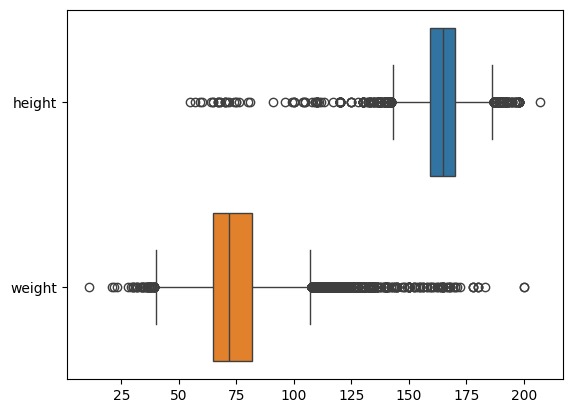

In [435]:
height_weight = df.loc[:,['height', 'weight']]
sns.boxplot(
    data=height_weight,
    orient='h'
)

#### 4.5.1.2 - Prune outliers

define 0.005 and 0.995 Quantile range to prune the remaining outliers

In [436]:
df = df[(df['weight'] > df['weight'].quantile(0.005)) & (df['weight'] < df['weight'].quantile(0.995))]
df = df[(df['height'] > df['height'].quantile(0.005)) & (df['height'] < df['height'].quantile(0.995))]

<Axes: >

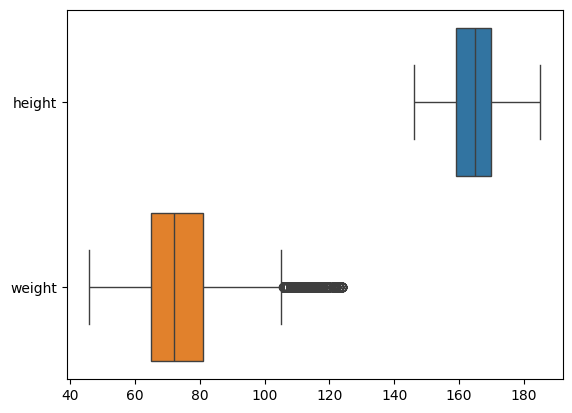

In [437]:
height_weight = df.loc[:,['height', 'weight']]
sns.boxplot(
    data=height_weight,
    orient='h'
)

### 4.5.2 - Systolic and diastolic blood pressure outliers

<Axes: >

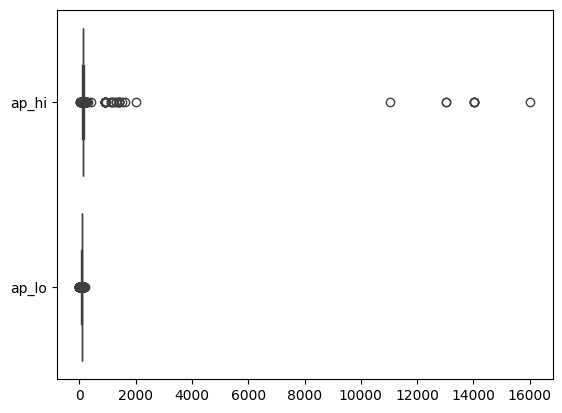

In [438]:
blood_pressure = df.loc[:,['ap_hi', 'ap_lo']]
sns.boxplot(
    data=blood_pressure,
    orient='h'
)

#### 4.5.2.1 - Prune outliers

define 0.005 and 0.995 Quantile range to prune the remaining outliers

In [439]:
df = df[(df['ap_hi'] > df['ap_hi'].quantile(0.005)) & (df['ap_hi'] < df['ap_hi'].quantile(0.995))]
df = df[(df['ap_lo'] > df['ap_lo'].quantile(0.005)) & (df['ap_lo'] < df['ap_lo'].quantile(0.995))]

<Axes: >

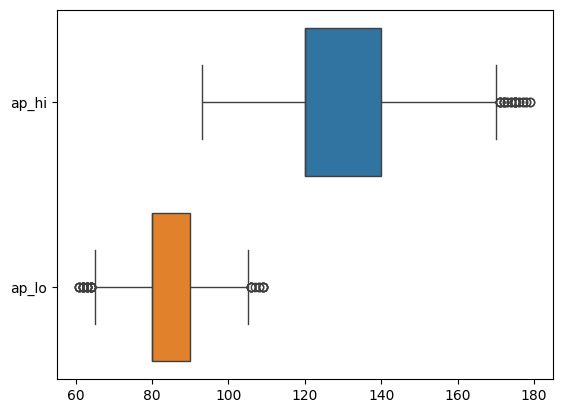

In [440]:
blood_pressure = df.loc[:,['ap_hi', 'ap_lo']]
sns.boxplot(
    data=blood_pressure,
    orient='h'
)

## 4.6 - Handling duplicate values

In [441]:
df.duplicated().sum()

3551

In [442]:
df[df.duplicated()]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
211,55,1,155,69.0,140,90,2,1,0,0,1,0
222,50,1,171,74.0,130,80,1,2,0,0,1,0
252,58,2,164,62.0,120,80,1,1,0,0,1,0
337,56,1,160,60.0,120,80,1,1,0,0,1,0
407,41,2,165,60.0,120,80,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
63362,53,2,175,80.0,120,80,1,1,0,0,1,1
63386,42,1,158,55.0,110,70,1,1,0,0,1,0
63417,54,1,165,72.0,120,80,1,1,0,0,1,0
63420,50,2,180,78.0,120,80,1,1,0,0,1,0


In [443]:
df.drop_duplicates(inplace=True)

## 4.7 - Post-clean review

In [444]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54548 entries, 0 to 63433
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          54548 non-null  int64  
 1   gender       54548 non-null  int64  
 2   height       54548 non-null  int64  
 3   weight       54548 non-null  float64
 4   ap_hi        54548 non-null  int64  
 5   ap_lo        54548 non-null  int64  
 6   cholesterol  54548 non-null  int64  
 7   gluc         54548 non-null  int64  
 8   smoke        54548 non-null  int64  
 9   alco         54548 non-null  int64  
 10  active       54548 non-null  int64  
 11  cardio       54548 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 5.4 MB


In [445]:
df.memory_usage(index=True).sum() / 1000000

5.672992

In [446]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [447]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,54548.000000,54548.000000,54548.000000,54548.000000,54548.000000,54548.00000,54548.000000,54548.000000,54548.000000,54548.000000,54548.000000,54548.000000
mean,53.326116,1.361681,164.577950,74.318816,126.594559,81.70635,1.371709,1.234381,0.092909,0.056372,0.798581,0.472391
std,6.797830,0.480492,7.554149,13.324014,14.418978,7.81535,0.683237,0.581528,0.290308,0.230641,0.401064,0.499242
min,30.000000,1.000000,146.000000,46.000000,93.000000,61.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.00000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.00000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.00000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,185.000000,124.000000,179.000000,109.00000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


# 5 - Data Engineering

## 5.1 Body mass index

BMI = weight (kg) / (height (m))^2

In [448]:
df["bmi"] = df["weight"]/((df["height"]/100)**2)

## 5.2 Pulse pressure

PP = ap_hi - ap_lo

In [449]:
df["pp"] = df["ap_hi"] - df["ap_lo"]

## 5.3 Post-data engineering review

In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54548 entries, 0 to 63433
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          54548 non-null  int64  
 1   gender       54548 non-null  int64  
 2   height       54548 non-null  int64  
 3   weight       54548 non-null  float64
 4   ap_hi        54548 non-null  int64  
 5   ap_lo        54548 non-null  int64  
 6   cholesterol  54548 non-null  int64  
 7   gluc         54548 non-null  int64  
 8   smoke        54548 non-null  int64  
 9   alco         54548 non-null  int64  
 10  active       54548 non-null  int64  
 11  cardio       54548 non-null  int64  
 12  bmi          54548 non-null  float64
 13  pp           54548 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 6.2 MB


In [451]:
df.memory_usage(index=True).sum() / 1000000

6.54576

In [452]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi', 'pp'],
      dtype='object')

In [453]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pp
count,54548.000000,54548.000000,54548.000000,54548.000000,54548.000000,54548.00000,54548.000000,54548.000000,54548.000000,54548.000000,54548.000000,54548.000000,54548.000000,54548.000000
mean,53.326116,1.361681,164.577950,74.318816,126.594559,81.70635,1.371709,1.234381,0.092909,0.056372,0.798581,0.472391,27.483130,44.888209
std,6.797830,0.480492,7.554149,13.324014,14.418978,7.81535,0.683237,0.581528,0.290308,0.230641,0.401064,0.499242,4.922222,10.520767
min,30.000000,1.000000,146.000000,46.000000,93.000000,61.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,14.609204,9.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.00000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.889463,40.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.00000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.543210,40.000000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.00000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.297784,50.000000
max,65.000000,2.000000,185.000000,124.000000,179.000000,109.00000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,56.295740,108.000000


# 6 - Data Visualisation

## 6.1 - PP w.r.t. CVD

/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_88880/2669965145.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  pp_cvd_bar.set_xticklabels(pp_cvd_bar.get_xticklabels(), rotation=-90)


Text(0, 0.5, 'Normalised CVD Presence')

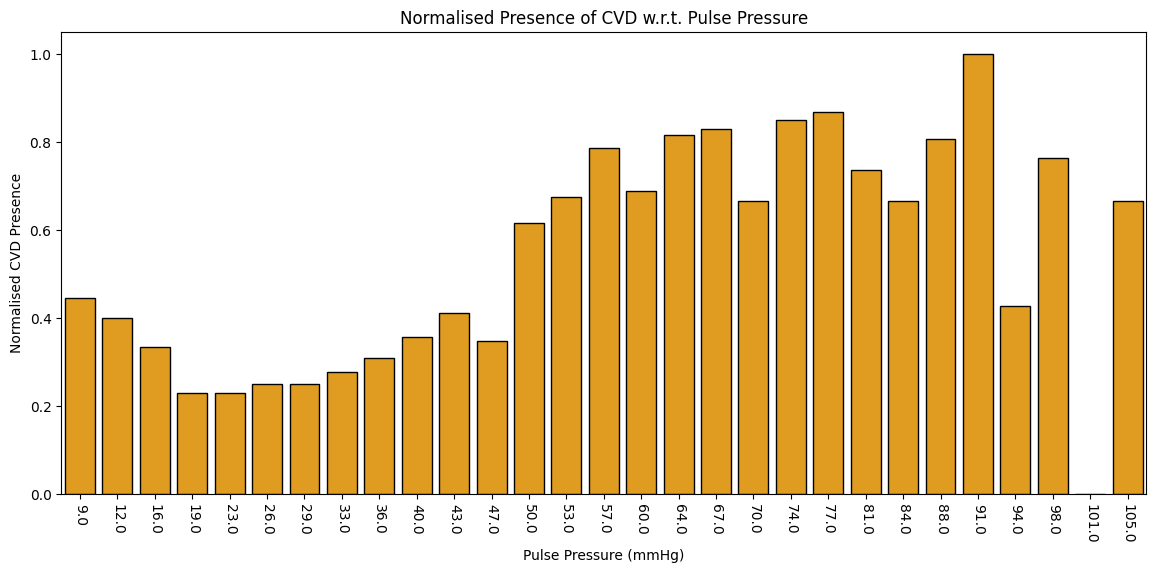

In [454]:
fig, axes = plt.subplots(figsize=(14, 6))

cvd_present = df[df['cardio'] == 1]
cvd_absent = df[df['cardio'] == 0]

num_bins = 30
bins=np.linspace(df['pp'].min(),df['pp'].max(),num_bins)

pp_cvd_present_hist = np.histogram(cvd_present['pp'],bins=bins)
pp_cvd_absent_hist = np.histogram(cvd_absent['pp'],bins=bins)

pp_cvd_rates = pp_cvd_present_hist[0]/(pp_cvd_present_hist[0]+pp_cvd_absent_hist[0])

pp_cvd_bar = sns.barplot(
    x=bins[:-1].round(),
    y=pp_cvd_rates,
    ax=axes,
    color='orange',
    edgecolor="0",
)
pp_cvd_bar.set_title("Normalised Presence of CVD w.r.t. Pulse Pressure")
pp_cvd_bar.set_xticklabels(pp_cvd_bar.get_xticklabels(), rotation=-90)
pp_cvd_bar.set_xlabel("Pulse Pressure (mmHg)")
pp_cvd_bar.set_ylabel("Normalised CVD Presence")

## 6.2 - Smoking w.r.t. CVD

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

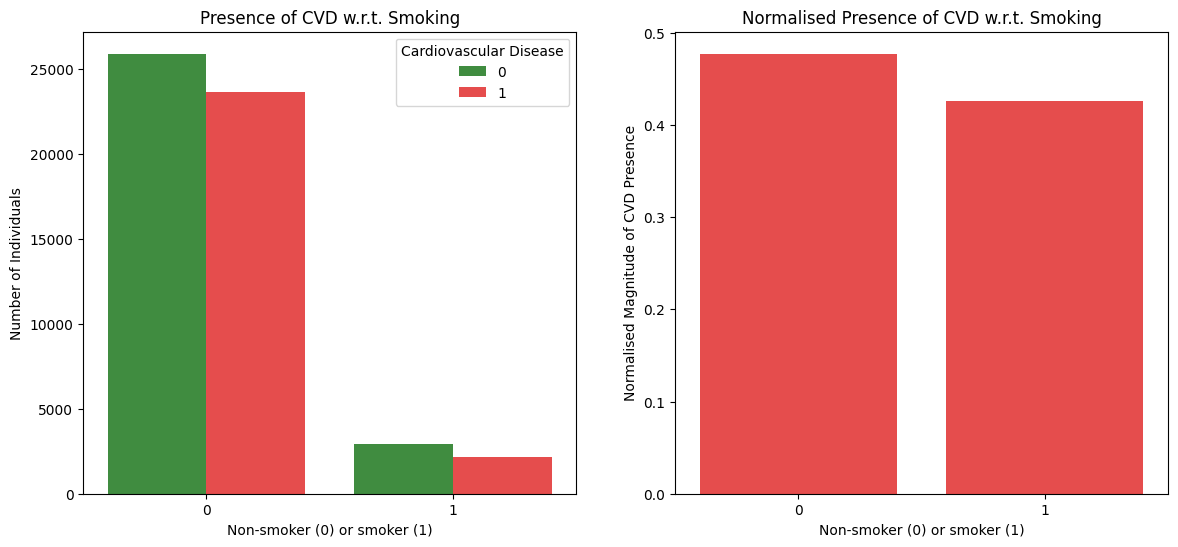

In [455]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grouping by 'smoke' and 'cardio' columns and calculating counts
grouped = df.groupby(['smoke', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='smoke', var_name='Cardiovascular Disease', value_name='Count')

smoke_cvd_bar = sns.barplot(
    data=melted,
    x='smoke',
    y='Count',
    hue='Cardiovascular Disease',
    palette={0: 'green', 1: 'red'},
    alpha=0.8,
    ax=axes[0]
)
smoke_cvd_bar.set_title("Presence of CVD w.r.t. Smoking")
smoke_cvd_bar.set_xlabel("Non-smoker (0) or smoker (1)")
smoke_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df.groupby('smoke').size().reset_index(name='Total')
grouped_cvd = df[df['cardio'] == 1].groupby('smoke').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='smoke')

# Calculate percentages
merged['Percentage_CVD'] = merged['CVD'] / merged['Total']

# Plotting the stacked bar plot
smoke_cvd_norm_bar = sns.barplot(
    data=merged,
    x='smoke',
    y='Percentage_CVD',
    color='red',
    alpha=0.8,
    ax=axes[1]
)
smoke_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Smoking")
smoke_cvd_norm_bar.set_xlabel("Non-smoker (0) or smoker (1)")
smoke_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 6.3 - Cholesterol w.r.t. CVD

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

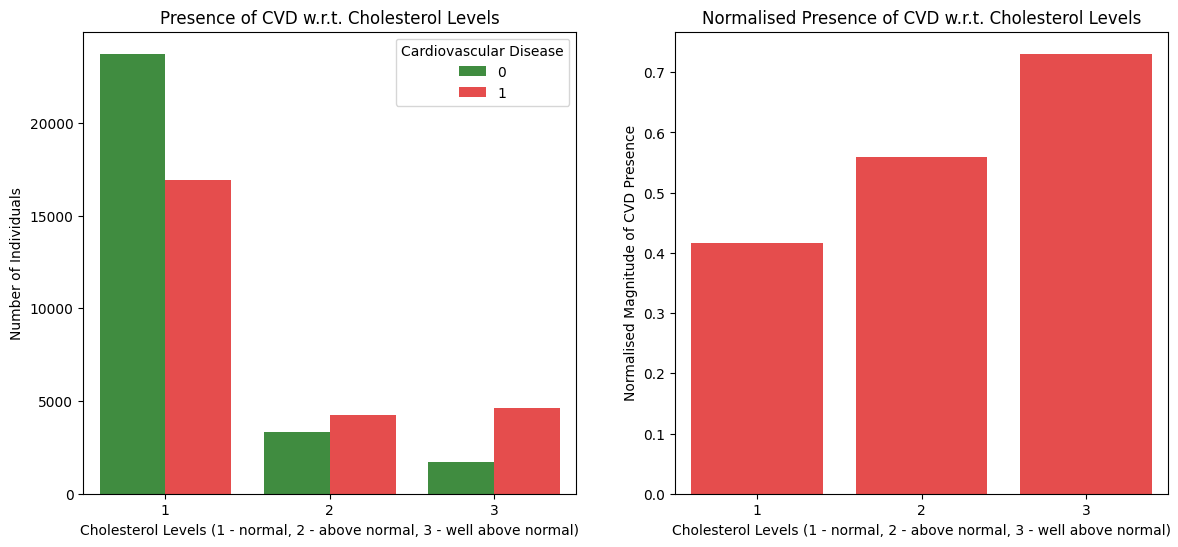

In [456]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grouping by 'cholesterol' and 'cardio' columns and calculating counts
grouped = df.groupby(['cholesterol', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='cholesterol', var_name='Cardiovascular Disease', value_name='Count')

chol_cvd_bar = sns.barplot(data=melted, x='cholesterol', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0])
chol_cvd_bar.set_title("Presence of CVD w.r.t. Cholesterol Levels")
chol_cvd_bar.set_xlabel("Cholesterol Levels (1 - normal, 2 - above normal, 3 - well above normal)")
chol_cvd_bar.set_ylabel("Number of Individuals")



# Calculate percentages
grouped_total = df.groupby('cholesterol').size().reset_index(name='Total')
grouped_cvd = df[df['cardio'] == 1].groupby('cholesterol').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='cholesterol')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
chol_cvd_norm_bar = sns.barplot(data=merged, x='cholesterol', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[1])
chol_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Cholesterol Levels")
chol_cvd_norm_bar.set_xlabel("Cholesterol Levels (1 - normal, 2 - above normal, 3 - well above normal)")
chol_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 6.4 - Glucose w.r.t. CVD

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

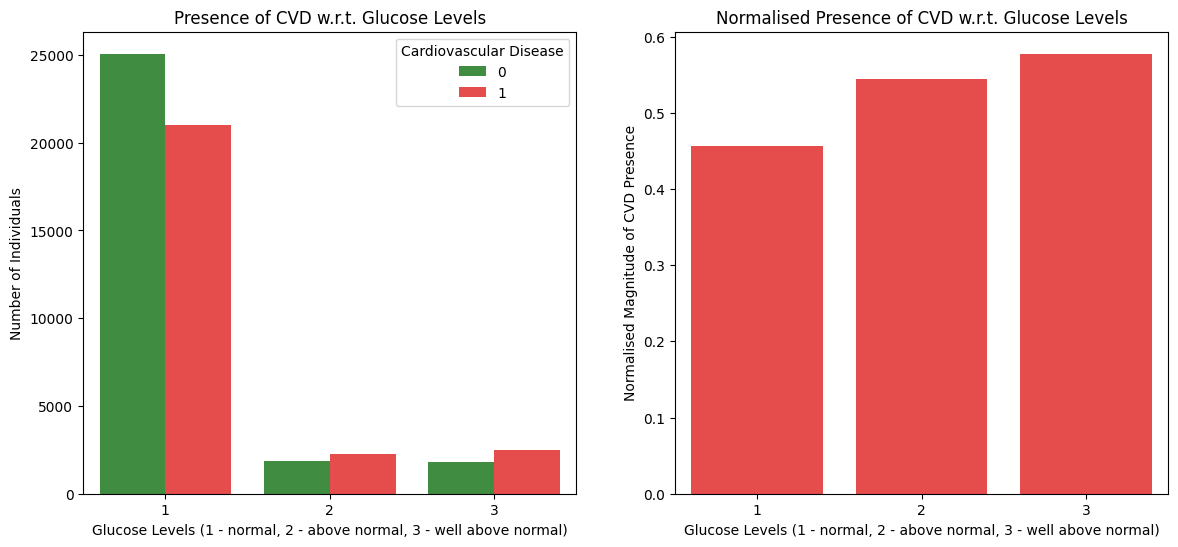

In [457]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grouping by 'gluc' and 'cardio' columns and calculating counts
grouped = df.groupby(['gluc', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='gluc', var_name='Cardiovascular Disease', value_name='Count')

gluc_cvd_bar = sns.barplot(data=melted, x='gluc', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0])
gluc_cvd_bar.set_title("Presence of CVD w.r.t. Glucose Levels")
gluc_cvd_bar.set_xlabel("Glucose Levels (1 - normal, 2 - above normal, 3 - well above normal)")
gluc_cvd_bar.set_ylabel("Number of Individuals")


# Calculate percentages
grouped_total = df.groupby('gluc').size().reset_index(name='Total')
grouped_cvd = df[df['cardio'] == 1].groupby('gluc').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='gluc')

# Calculate percentages
merged['Percentage_gluc'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
gluc_cvd_norm_bar = sns.barplot(data=merged, x='gluc', y='Percentage_gluc', color='red',  alpha=0.8, ax=axes[1])
gluc_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Glucose Levels")
gluc_cvd_norm_bar.set_xlabel("Glucose Levels (1 - normal, 2 - above normal, 3 - well above normal)")
gluc_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 6.5 - Activity w.r.t. CVD

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

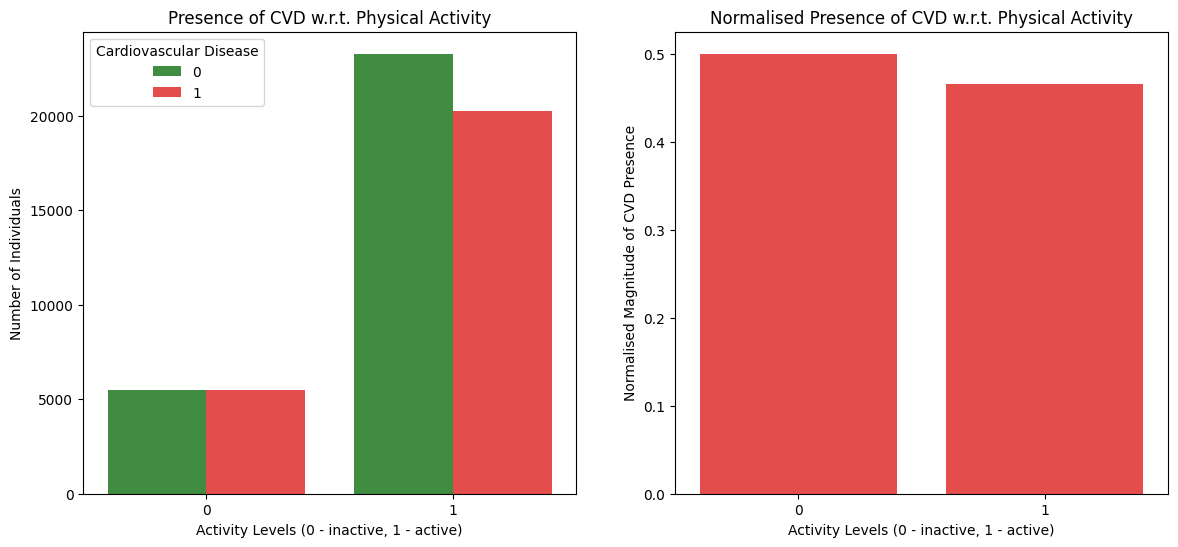

In [458]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grouping by 'active' and 'cardio' columns and calculating counts
grouped = df.groupby(['active', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='active', var_name='Cardiovascular Disease', value_name='Count')

# Plotting the grouped bar plot
inac_cvd_bar = sns.barplot(data=melted, x='active', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0])
inac_cvd_bar.set_title("Presence of CVD w.r.t. Physical Activity")
inac_cvd_bar.set_xlabel("Activity Levels (0 - inactive, 1 - active)")
inac_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df.groupby('active').size().reset_index(name='Total')
grouped_cvd = df[df['cardio'] == 1].groupby('active').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='active')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
inac_cvd_norm_bar = sns.barplot(data=merged, x='active', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[1])
inac_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Physical Activity")
inac_cvd_norm_bar.set_xlabel("Activity Levels (0 - inactive, 1 - active)")
inac_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 6.6 - BMI w.r.t. CVD

/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_88880/359972184.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bmi_cvd_norm_bar.set_xticklabels(bmi_cvd_norm_bar.get_xticklabels(), rotation=-90)


Text(0, 0.5, 'Normalised CVD Presence')

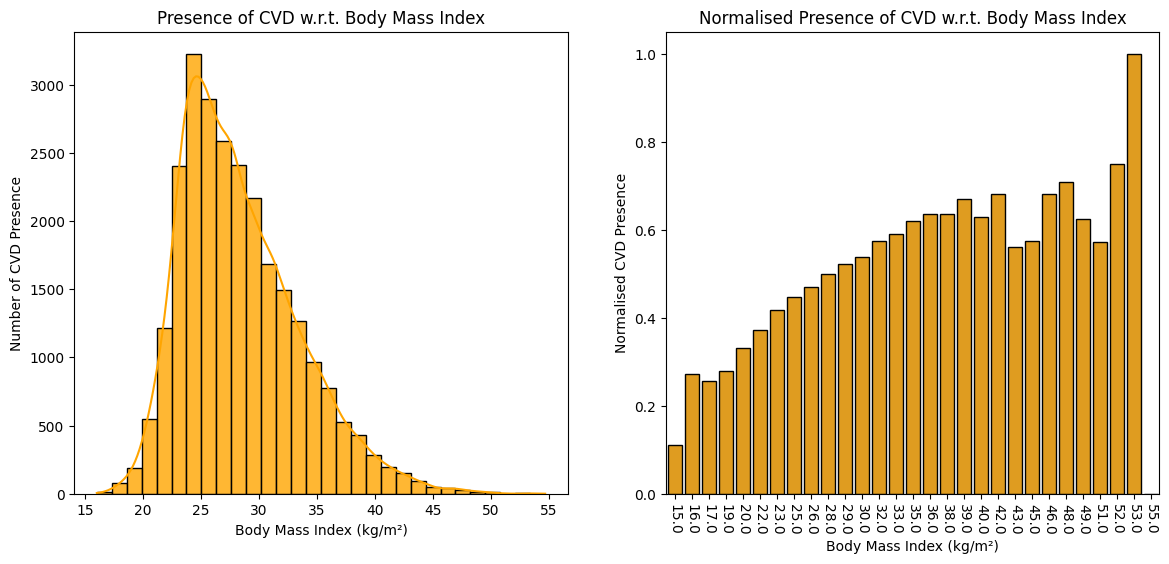

In [459]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cvd_present = df[df['cardio'] == 1]
cvd_absent = df[df['cardio'] == 0]

bmi_cvd_hist = sns.histplot(data=cvd_present, x='bmi', bins=30, kde=True, color='orange', alpha=0.8, ax=axes[0])
bmi_cvd_hist.set_title("Presence of CVD w.r.t. Body Mass Index")
bmi_cvd_hist.set_xlabel("Body Mass Index (kg/m²)")
bmi_cvd_hist.set_ylabel("Number of CVD Presence")

num_bins = 30
bins=np.linspace(df['bmi'].min(),df['bmi'].max(),num_bins)

cvd_present_hist = np.histogram(cvd_present['bmi'],bins=bins)
cvd_absent_hist = np.histogram(cvd_absent['bmi'],bins=bins)

cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])

bmi_cvd_norm_bar = sns.barplot(
    x=bins[:-1].round(),
    y=cvd_rates,
    ax=axes[1],
    color='orange',
    edgecolor="0",
)
bmi_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Body Mass Index")
bmi_cvd_norm_bar.set_xticklabels(bmi_cvd_norm_bar.get_xticklabels(), rotation=-90)
bmi_cvd_norm_bar.set_xlabel("Body Mass Index (kg/m²)")
bmi_cvd_norm_bar.set_ylabel("Normalised CVD Presence")

## 6.7 - Age w.r.t. CVD

/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_88880/4109128432.py:17: RuntimeWarning: invalid value encountered in divide
  cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])
/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_88880/4109128432.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  age_cvd_norm_bar.set_xticklabels(age_cvd_norm_bar.get_xticklabels(), rotation=-90)


Text(0, 0.5, 'Normalised CVD Presence')

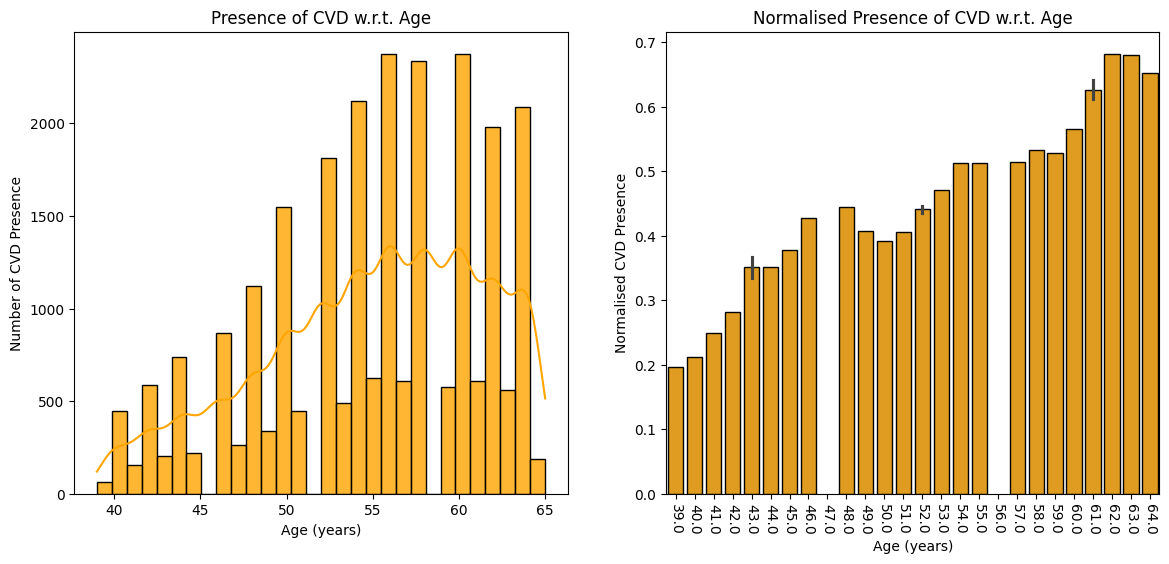

In [460]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cvd_present = df[df['cardio'] == 1]
cvd_absent = df[df['cardio'] == 0]

age_cvd_hist = sns.histplot(data=cvd_present, x='age', bins=30, kde=True, color='orange', alpha=0.8, ax=axes[0])
age_cvd_hist.set_title("Presence of CVD w.r.t. Age")
age_cvd_hist.set_xlabel("Age (years)")
age_cvd_hist.set_ylabel("Number of CVD Presence")

num_bins = 30
bins=np.linspace(39,df['age'].max(),num_bins)

cvd_present_hist = np.histogram(cvd_present['age'],bins=bins)
cvd_absent_hist = np.histogram(cvd_absent['age'],bins=bins)

cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])

age_cvd_norm_bar = sns.barplot(
    x=bins[:-1].round(),
    y=cvd_rates,
    ax=axes[1],
    color='orange',
    edgecolor="0",
)
age_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Age")
age_cvd_norm_bar.set_xticklabels(age_cvd_norm_bar.get_xticklabels(), rotation=-90)
age_cvd_norm_bar.set_xlabel("Age (years)")
age_cvd_norm_bar.set_ylabel("Normalised CVD Presence")

## 6.8 - Gender w.r.t. CVD

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

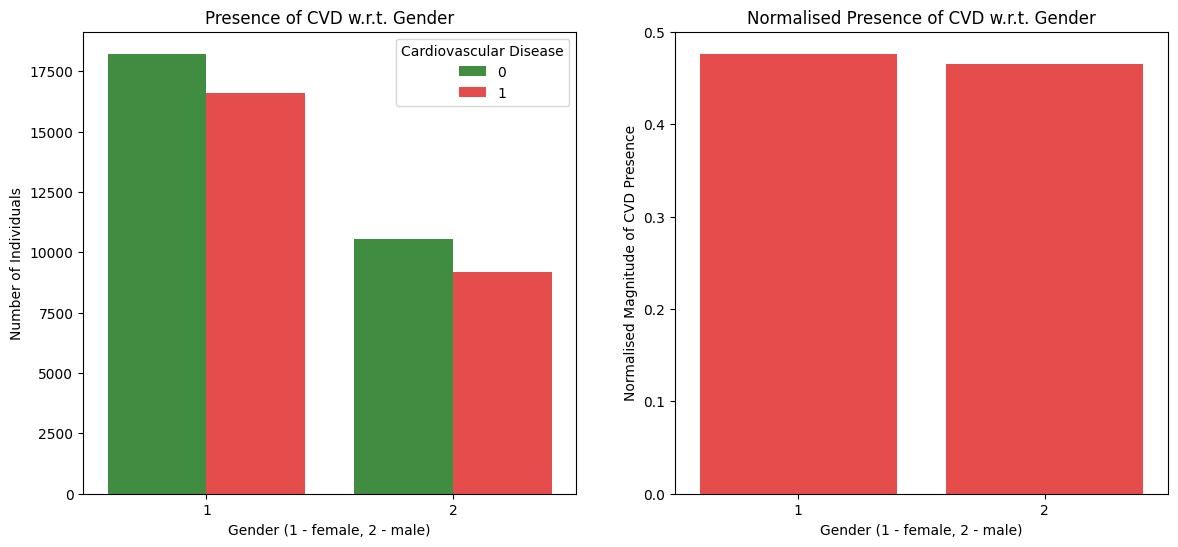

In [461]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grouping by 'gender' and 'cardio' columns and calculating counts
grouped = df.groupby(['gender', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='gender', var_name='Cardiovascular Disease', value_name='Count')

gen_cvd_bar = sns.barplot(data=melted, x='gender', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0])
gen_cvd_bar.set_title("Presence of CVD w.r.t. Gender")
gen_cvd_bar.set_xlabel("Gender (1 - female, 2 - male)")
gen_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df.groupby('gender').size().reset_index(name='Total')
grouped_cvd = df[df['cardio'] == 1].groupby('gender').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='gender')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])
# Plotting the stacked bar plot
gen_cvd_norm_bar = sns.barplot(data=merged, x='gender', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[1])
gen_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Gender")
gen_cvd_norm_bar.set_xlabel("Gender (1 - female, 2 - male)")
gen_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 6.9 - Age w.r.t. Gender w.r.t. CVD

/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_88880/3569121369.py:17: RuntimeWarning: invalid value encountered in divide
  cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])
/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_88880/3569121369.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  female_cvd_norm_bar.set_xticklabels(female_cvd_norm_bar.get_xticklabels(), rotation=-90)
/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_88880/3569121369.py:49: RuntimeWarning: invalid value encountered in divide
  cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])
/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_88880/3569121369.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  male_cvd_norm_bar.set_xticklabels(male_cvd_norm_bar.get_xticklabe

Text(0, 0.5, 'Normalised CVD Presence')

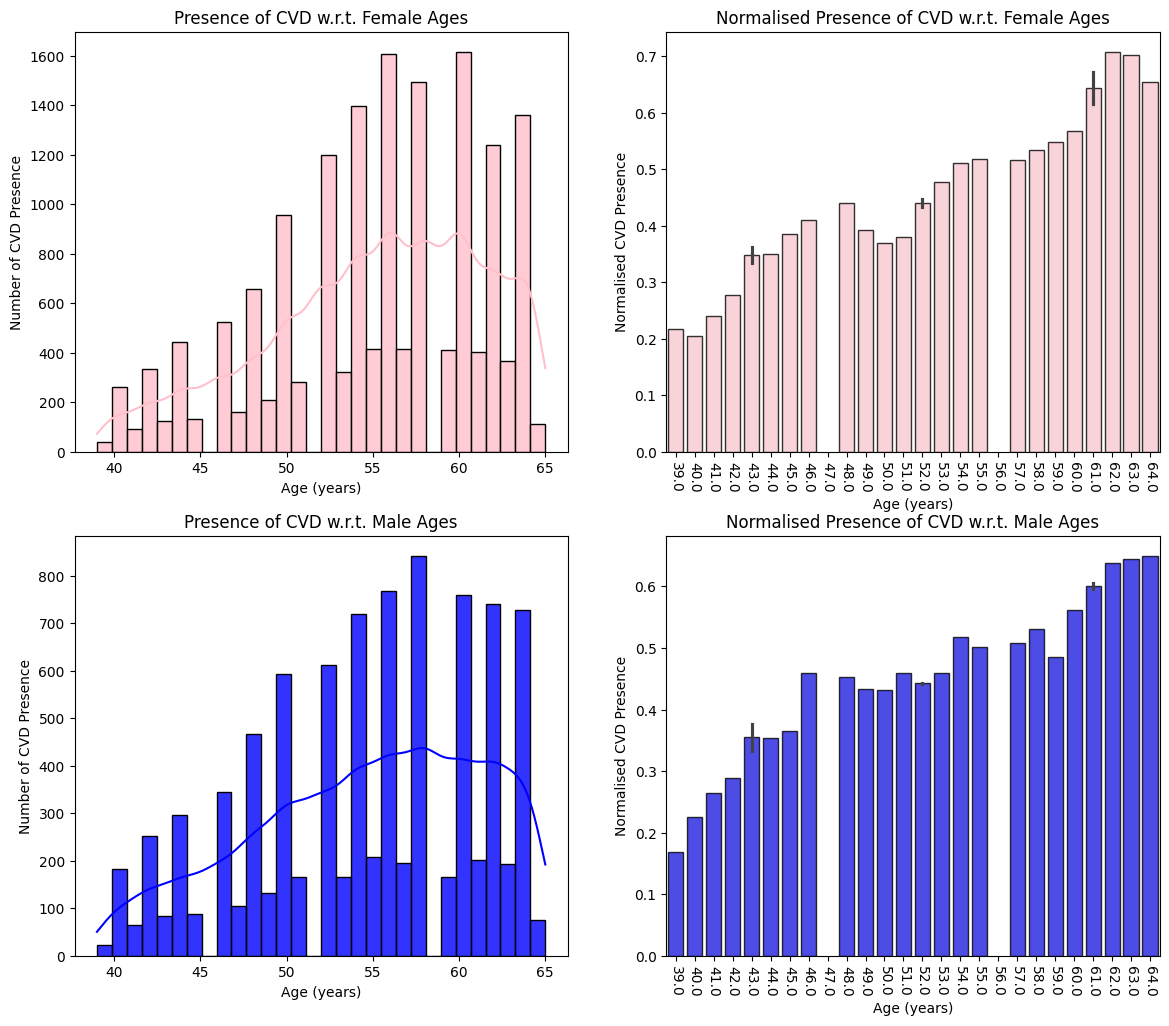

In [462]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

female_cvd_present = df[(df['cardio'] == 1) & (df['gender'] == 1)]
female_cvd_absent = df[(df['cardio'] == 0) & (df['gender'] == 1)]

female_cvd_hist = sns.histplot(data=female_cvd_present, x='age', bins=30, kde=True, color='pink', alpha=0.8, ax=axes[0, 0])
female_cvd_hist.set_title("Presence of CVD w.r.t. Female Ages")
female_cvd_hist.set_xlabel("Age (years)")
female_cvd_hist.set_ylabel("Number of CVD Presence")

num_bins = 30
bins=np.linspace(39,df['age'].max(),num_bins)

cvd_present_hist = np.histogram(female_cvd_present['age'],bins=bins)
cvd_absent_hist = np.histogram(female_cvd_absent['age'],bins=bins)

cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])

female_cvd_norm_bar = sns.barplot(
    x=bins[:-1].round(),
    y=cvd_rates,
    ax=axes[0,1],
    color='pink',
    alpha=0.8,
    edgecolor="0",
)
female_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Female Ages")
female_cvd_norm_bar.set_xticklabels(female_cvd_norm_bar.get_xticklabels(), rotation=-90)
female_cvd_norm_bar.set_xlabel("Age (years)")
female_cvd_norm_bar.set_ylabel("Normalised CVD Presence")




male_cvd_present = df[(df['cardio'] == 1) & (df['gender'] == 2)]
male_cvd_absent = df[(df['cardio'] == 0) & (df['gender'] == 2)]

male_cvd_hist = sns.histplot(data=male_cvd_present, x='age', bins=30, kde=True, color='blue', alpha=0.8, ax=axes[1, 0])
male_cvd_hist.set_title("Presence of CVD w.r.t. Male Ages")
male_cvd_hist.set_xlabel("Age (years)")
male_cvd_hist.set_ylabel("Number of CVD Presence")

num_bins = 30
bins=np.linspace(39,df['age'].max(),num_bins)

cvd_present_hist = np.histogram(male_cvd_present['age'],bins=bins)
cvd_absent_hist = np.histogram(male_cvd_absent['age'],bins=bins)

cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])

male_cvd_norm_bar = sns.barplot(
    x=bins[:-1].round(),
    y=cvd_rates,
    ax=axes[1,1],
    color='blue',
    alpha=0.8,
    edgecolor="0",
)
male_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Male Ages")
male_cvd_norm_bar.set_xticklabels(male_cvd_norm_bar.get_xticklabels(), rotation=-90)
male_cvd_norm_bar.set_xlabel("Age (years)")
male_cvd_norm_bar.set_ylabel("Normalised CVD Presence")

## 6.10 - Alcohol w.r.t. CVD

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

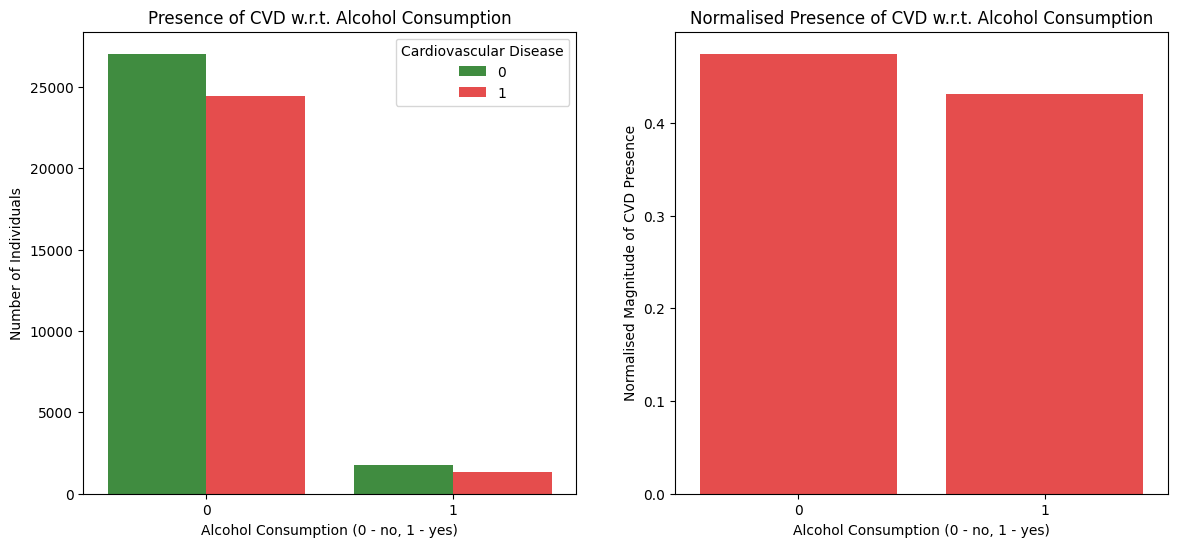

In [463]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grouping by 'alco' and 'cardio' columns and calculating counts
grouped = df.groupby(['alco', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='alco', var_name='Cardiovascular Disease', value_name='Count')

# Plotting the grouped bar plot
alco_cvd_bar = sns.barplot(data=melted, x='alco', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0])
alco_cvd_bar.set_title("Presence of CVD w.r.t. Alcohol Consumption")
alco_cvd_bar.set_xlabel("Alcohol Consumption (0 - no, 1 - yes)")
alco_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df.groupby('alco').size().reset_index(name='Total')
grouped_cvd = df[df['cardio'] == 1].groupby('alco').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='alco')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
alco_cvd_norm_bar = sns.barplot(data=merged, x='alco', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[1])
alco_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Alcohol Consumption")
alco_cvd_norm_bar.set_xlabel("Alcohol Consumption (0 - no, 1 - yes)")
alco_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

# 7 - Balancing Data

## 7.1 - Smoker data

### 7.1.1 - Oversample re-sampling

In [464]:
# create dataframes for majority and minority classes
df_non_smokers = df[df['smoke'] == 0]
df_smokers = df[df['smoke'] == 1]

# upsample minority class
df_smokers_upsampled = resample(
    df_smokers,
    replace=True,
    n_samples=len(df_non_smokers),
    random_state=42
)

# combine majority class with upsampled minority class
df_smokers_resampled = pd.concat([df_smokers_upsampled, df_non_smokers])

print(len(df_non_smokers), len(df_smokers_upsampled))

49480 49480


### 7.1.2 - SMOTE

In [465]:
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(random_state=42)

df_sm = df.copy()

# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(df_sm.drop('smoke', axis=1), df_sm['smoke'])
df_smokers_smote = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

### 7.1.3 - ADASYN

In [466]:
# Resampling the minority class. The strategy can be changed as required.
ada = ADASYN(sampling_strategy='minority', random_state=42)

df_ada = df.copy()

# Fit the model to generate the data.
oversampled_X, oversampled_Y = ada.fit_resample(df_ada.drop('smoke', axis=1), df_ada['smoke'])
df_smokers_adasyn = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

### 7.1.4 - Visualisation

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

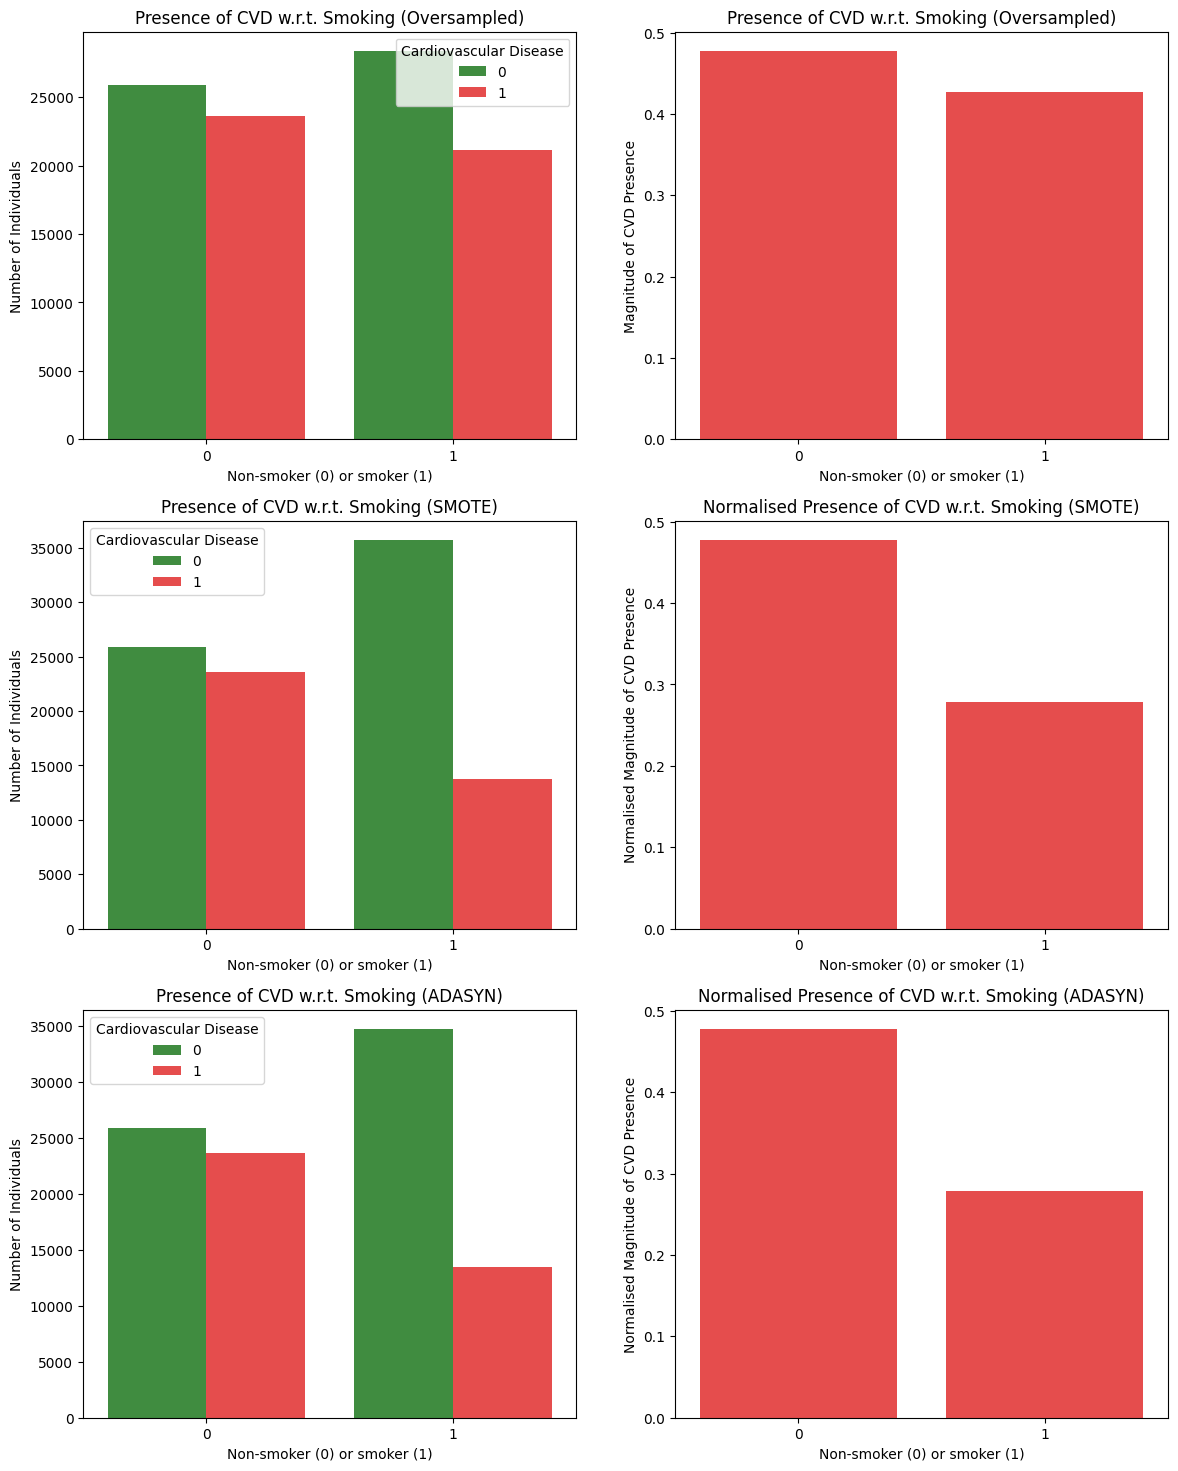

In [467]:
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# Grouping by 'smoke' and 'cardio' columns and calculating counts
grouped = df_smokers_resampled.groupby(['smoke', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='smoke', var_name='Cardiovascular Disease', value_name='Count')

smoke_res_cvd_bar = sns.barplot(
    data=melted,
    x='smoke',
    y='Count',
    hue='Cardiovascular Disease',
    palette={0: 'green', 1: 'red'},
    alpha=0.8,
    ax=axes[0, 0]
)
smoke_res_cvd_bar.set_title("Presence of CVD w.r.t. Smoking (Oversampled)")
smoke_res_cvd_bar.set_xlabel("Non-smoker (0) or smoker (1)")
smoke_res_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df_smokers_resampled.groupby('smoke').size().reset_index(name='Total')
grouped_cvd = df_smokers_resampled[df_smokers_resampled['cardio'] == 1].groupby('smoke').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='smoke')

# Calculate percentages
merged['Percentage_CVD'] = merged['CVD'] / merged['Total']

# Plotting the stacked bar plot
smoke_res_cvd_norm_bar = sns.barplot(
    data=merged,
    x='smoke',
    y='Percentage_CVD',
    color='red',
    alpha=0.8,
    ax=axes[0, 1]
)
smoke_res_cvd_norm_bar.set_title("Presence of CVD w.r.t. Smoking (Oversampled)")
smoke_res_cvd_norm_bar.set_xlabel("Non-smoker (0) or smoker (1)")
smoke_res_cvd_norm_bar.set_ylabel("Magnitude of CVD Presence")




# Grouping by 'smoke' and 'cardio' columns and calculating counts
grouped = df_smokers_smote.groupby(['smoke', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='smoke', var_name='Cardiovascular Disease', value_name='Count')

smoke_smote_cvd_bar = sns.barplot(
    data=melted,
    x='smoke',
    y='Count',
    hue='Cardiovascular Disease',
    palette={0: 'green', 1: 'red'},
    alpha=0.8,
    ax=axes[1, 0]
)
smoke_smote_cvd_bar.set_title("Presence of CVD w.r.t. Smoking (SMOTE)")
smoke_smote_cvd_bar.set_xlabel("Non-smoker (0) or smoker (1)")
smoke_smote_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df_smokers_smote.groupby('smoke').size().reset_index(name='Total')
grouped_cvd = df_smokers_smote[df_smokers_smote['cardio'] == 1].groupby('smoke').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='smoke')

# Calculate percentages
merged['Percentage_CVD'] = merged['CVD'] / merged['Total']

# Plotting the stacked bar plot
smoke_smote_cvd_norm_bar = sns.barplot(
    data=merged,
    x='smoke',
    y='Percentage_CVD',
    color='red',
    alpha=0.8,
    ax=axes[1, 1]
)
smoke_smote_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Smoking (SMOTE)")
smoke_smote_cvd_norm_bar.set_xlabel("Non-smoker (0) or smoker (1)")
smoke_smote_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")



# Grouping by 'smoke' and 'cardio' columns and calculating counts
grouped = df_smokers_adasyn.groupby(['smoke', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='smoke', var_name='Cardiovascular Disease', value_name='Count')

smoke_adasyn_cvd_bar = sns.barplot(
    data=melted,
    x='smoke',
    y='Count',
    hue='Cardiovascular Disease',
    palette={0: 'green', 1: 'red'},
    alpha=0.8,
    ax=axes[2, 0]
)
smoke_adasyn_cvd_bar.set_title("Presence of CVD w.r.t. Smoking (ADASYN)")
smoke_adasyn_cvd_bar.set_xlabel("Non-smoker (0) or smoker (1)")
smoke_adasyn_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df_smokers_adasyn.groupby('smoke').size().reset_index(name='Total')
grouped_cvd = df_smokers_adasyn[df_smokers_adasyn['cardio'] == 1].groupby('smoke').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='smoke')

# Calculate percentages
merged['Percentage_CVD'] = merged['CVD'] / merged['Total']

# Plotting the stacked bar plot
smoke_adasyn_cvd_norm_bar = sns.barplot(
    data=merged,
    x='smoke',
    y='Percentage_CVD',
    color='red',
    alpha=0.8,
    ax=axes[2, 1]
)
smoke_adasyn_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Smoking (ADASYN)")
smoke_adasyn_cvd_norm_bar.set_xlabel("Non-smoker (0) or smoker (1)")
smoke_adasyn_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")



## 7.2 - Cholesterol data

### 7.2.1 - Oversample re-sampling

In [468]:
# create dataframes for majority and minority classes
df_chol_1 = df[df['cholesterol'] == 1]
df_chol_2 = df[df['cholesterol'] == 2]
df_chol_3 = df[df['cholesterol'] == 3]

# upsample minority class
df_chol_2_upsampled = resample(
    df_chol_2,
    replace=True,
    n_samples=len(df_chol_1),
    random_state=42
)
df_chol_3_upsampled = resample(
    df_chol_3,
    replace=True,
    n_samples=len(df_chol_1),
    random_state=42
)

# combine majority class with upsampled minority class
df_chol_resampled = pd.concat([df_chol_2_upsampled, df_chol_3_upsampled, df_chol_1])

print(len(df_chol_1), len(df_chol_2_upsampled), len(df_chol_3_upsampled))

40634 40634 40634


### 7.2.2 - SMOTE

In [469]:
# Resampling the minority class. The strategy can be changed as required.
# sm = SMOTE(sampling_strategy='minority', random_state=42)
sm = SMOTE(sampling_strategy={1: 40634, 2: 40634, 3: 40634}, random_state=42)

df_sm = df.copy()

# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(df_sm.drop('cholesterol', axis=1), df_sm['cholesterol'])
df_chol_smote = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

### 7.2.3 - ADASYN

In [470]:
# Resampling the minority class. The strategy can be changed as required.
ada = ADASYN(sampling_strategy={1: 40634, 2: 40634, 3: 40634}, random_state=42)

df_ada = df.copy()

# Fit the model to generate the data.
oversampled_X, oversampled_Y = ada.fit_resample(df_ada.drop('cholesterol', axis=1), df_ada['cholesterol'])
df_chol_adasyn = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

### 7.2.4 - Visualisation

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

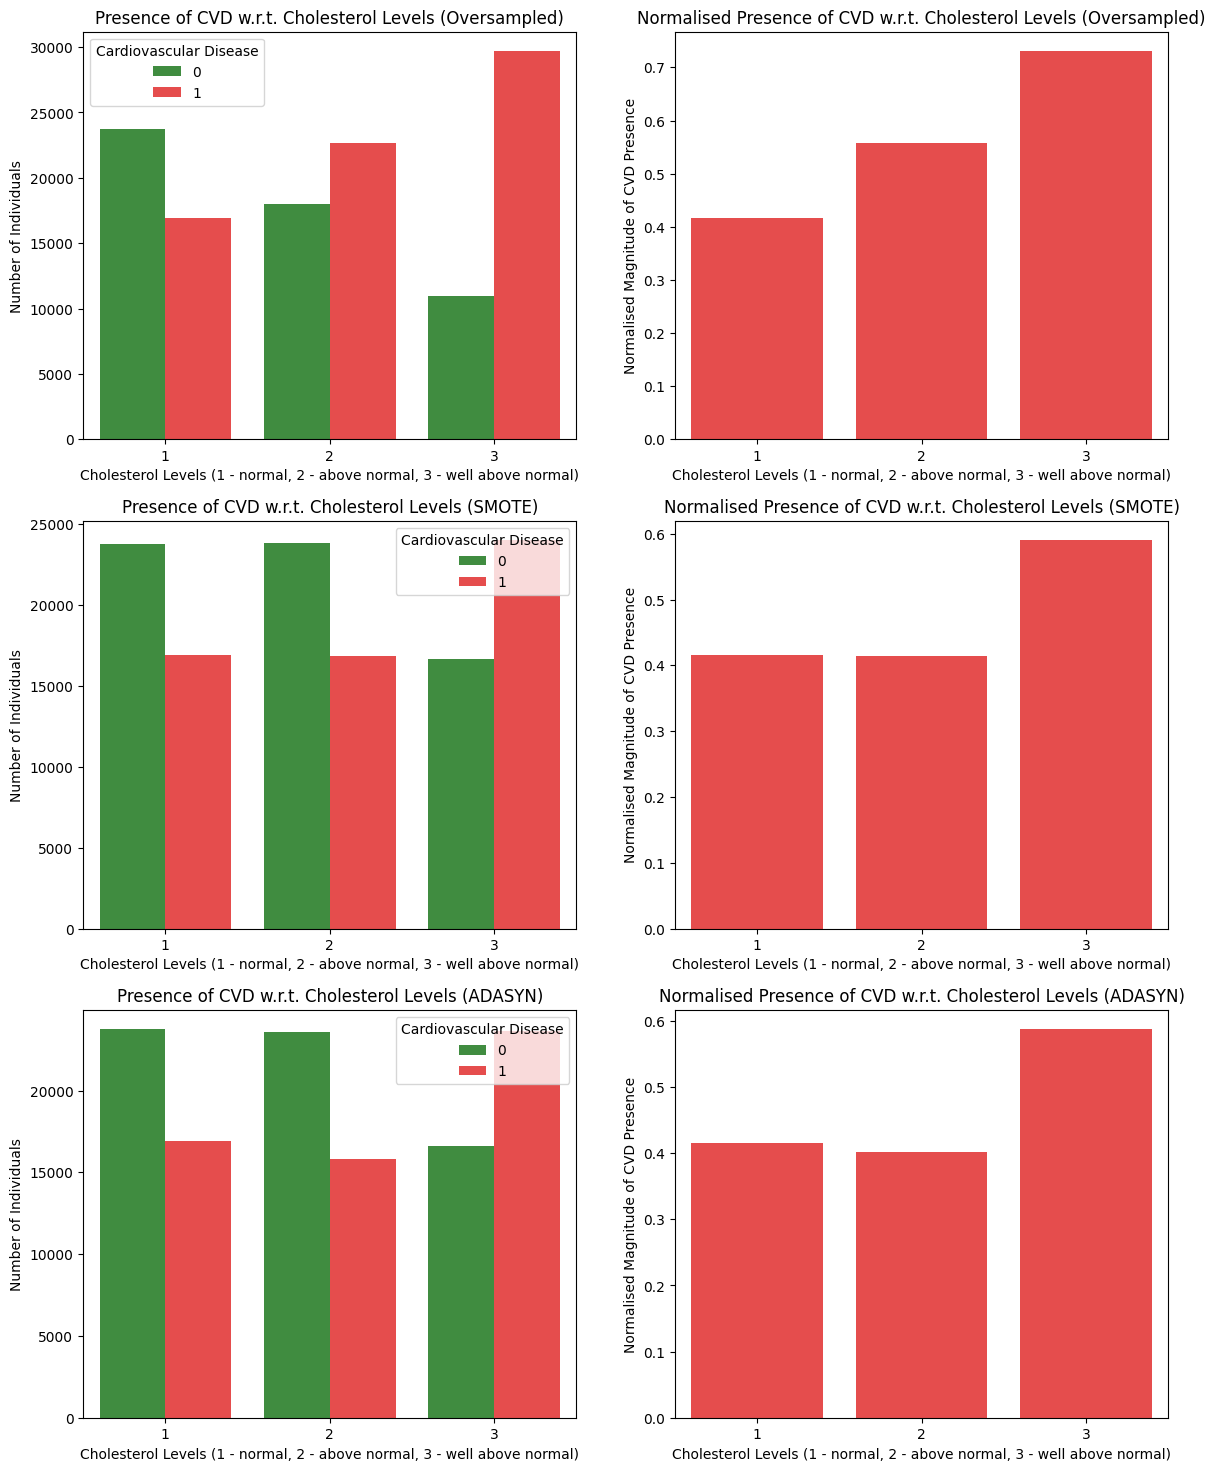

In [471]:
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# Grouping by 'cholesterol' and 'cardio' columns and calculating counts
grouped = df_chol_resampled.groupby(['cholesterol', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='cholesterol', var_name='Cardiovascular Disease', value_name='Count')

chol_res_cvd_bar = sns.barplot(data=melted, x='cholesterol', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0,0])
chol_res_cvd_bar.set_title("Presence of CVD w.r.t. Cholesterol Levels (Oversampled)")
chol_res_cvd_bar.set_xlabel("Cholesterol Levels (1 - normal, 2 - above normal, 3 - well above normal)")
chol_res_cvd_bar.set_ylabel("Number of Individuals")



# Calculate percentages
grouped_total = df_chol_resampled.groupby('cholesterol').size().reset_index(name='Total')
grouped_cvd = df_chol_resampled[df_chol_resampled['cardio'] == 1].groupby('cholesterol').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='cholesterol')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
chol_res_cvd_norm_bar = sns.barplot(data=merged, x='cholesterol', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[0,1])
chol_res_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Cholesterol Levels (Oversampled)")
chol_res_cvd_norm_bar.set_xlabel("Cholesterol Levels (1 - normal, 2 - above normal, 3 - well above normal)")
chol_res_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")



# Grouping by 'cholesterol' and 'cardio' columns and calculating counts
grouped = df_chol_smote.groupby(['cholesterol', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='cholesterol', var_name='Cardiovascular Disease', value_name='Count')

chol_smote_cvd_bar = sns.barplot(data=melted, x='cholesterol', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[1,0])
chol_smote_cvd_bar.set_title("Presence of CVD w.r.t. Cholesterol Levels (SMOTE)")
chol_smote_cvd_bar.set_xlabel("Cholesterol Levels (1 - normal, 2 - above normal, 3 - well above normal)")
chol_smote_cvd_bar.set_ylabel("Number of Individuals")



# Calculate percentages
grouped_total = df_chol_smote.groupby('cholesterol').size().reset_index(name='Total')
grouped_cvd = df_chol_smote[df_chol_smote['cardio'] == 1].groupby('cholesterol').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='cholesterol')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
chol_smote_cvd_norm_bar = sns.barplot(data=merged, x='cholesterol', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[1,1])
chol_smote_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Cholesterol Levels (SMOTE)")
chol_smote_cvd_norm_bar.set_xlabel("Cholesterol Levels (1 - normal, 2 - above normal, 3 - well above normal)")
chol_smote_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")




# Grouping by 'cholesterol' and 'cardio' columns and calculating counts
grouped = df_chol_adasyn.groupby(['cholesterol', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='cholesterol', var_name='Cardiovascular Disease', value_name='Count')

chol_ada_cvd_bar = sns.barplot(data=melted, x='cholesterol', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[2,0])
chol_ada_cvd_bar.set_title("Presence of CVD w.r.t. Cholesterol Levels (ADASYN)")
chol_ada_cvd_bar.set_xlabel("Cholesterol Levels (1 - normal, 2 - above normal, 3 - well above normal)")
chol_ada_cvd_bar.set_ylabel("Number of Individuals")



# Calculate percentages
grouped_total = df_chol_adasyn.groupby('cholesterol').size().reset_index(name='Total')
grouped_cvd = df_chol_adasyn[df_chol_adasyn['cardio'] == 1].groupby('cholesterol').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='cholesterol')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
chol_ada_cvd_norm_bar = sns.barplot(data=merged, x='cholesterol', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[2,1])
chol_ada_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Cholesterol Levels (ADASYN)")
chol_ada_cvd_norm_bar.set_xlabel("Cholesterol Levels (1 - normal, 2 - above normal, 3 - well above normal)")
chol_ada_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 7.3 - Glucose data

### 7.3.1 - Oversample re-sampling

In [472]:
# create dataframes for majority and minority classes
df_gluc_1 = df[df['gluc'] == 1]
df_gluc_2 = df[df['gluc'] == 2]
df_gluc_3 = df[df['gluc'] == 3]

# upsample minority class
df_gluc_2_upsampled = resample(
    df_gluc_2,
    replace=True,
    n_samples=len(df_gluc_1),
    random_state=42
)
df_gluc_3_upsampled = resample(
    df_gluc_3,
    replace=True,
    n_samples=len(df_gluc_1),
    random_state=42
)

# combine majority class with upsampled minority class
df_gluc_resampled = pd.concat([df_gluc_2_upsampled, df_gluc_3_upsampled, df_gluc_1])

print(len(df_gluc_1), len(df_gluc_2_upsampled), len(df_gluc_3_upsampled))

46092 46092 46092


### 7.3.2 - SMOTE

In [473]:
# Resampling the minority class. The strategy can be changed as required.
# sm = SMOTE(sampling_strategy='minority', random_state=42)
sm = SMOTE(sampling_strategy={1: 46092, 2: 46092, 3: 46092}, random_state=42)

df_sm = df.copy()

# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(df_sm.drop('gluc', axis=1), df_sm['gluc'])
df_gluc_smote = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

### 7.3.3 - ADASYN

In [474]:
# Resampling the minority class. The strategy can be changed as required.
ada = ADASYN(sampling_strategy={1: 46092, 2: 46092, 3: 46092}, random_state=42)

df_ada = df.copy()

# Fit the model to generate the data.
oversampled_X, oversampled_Y = ada.fit_resample(df_ada.drop('gluc', axis=1), df_ada['gluc'])
df_gluc_adasyn = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

### 7.3.4 - Visualisation

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

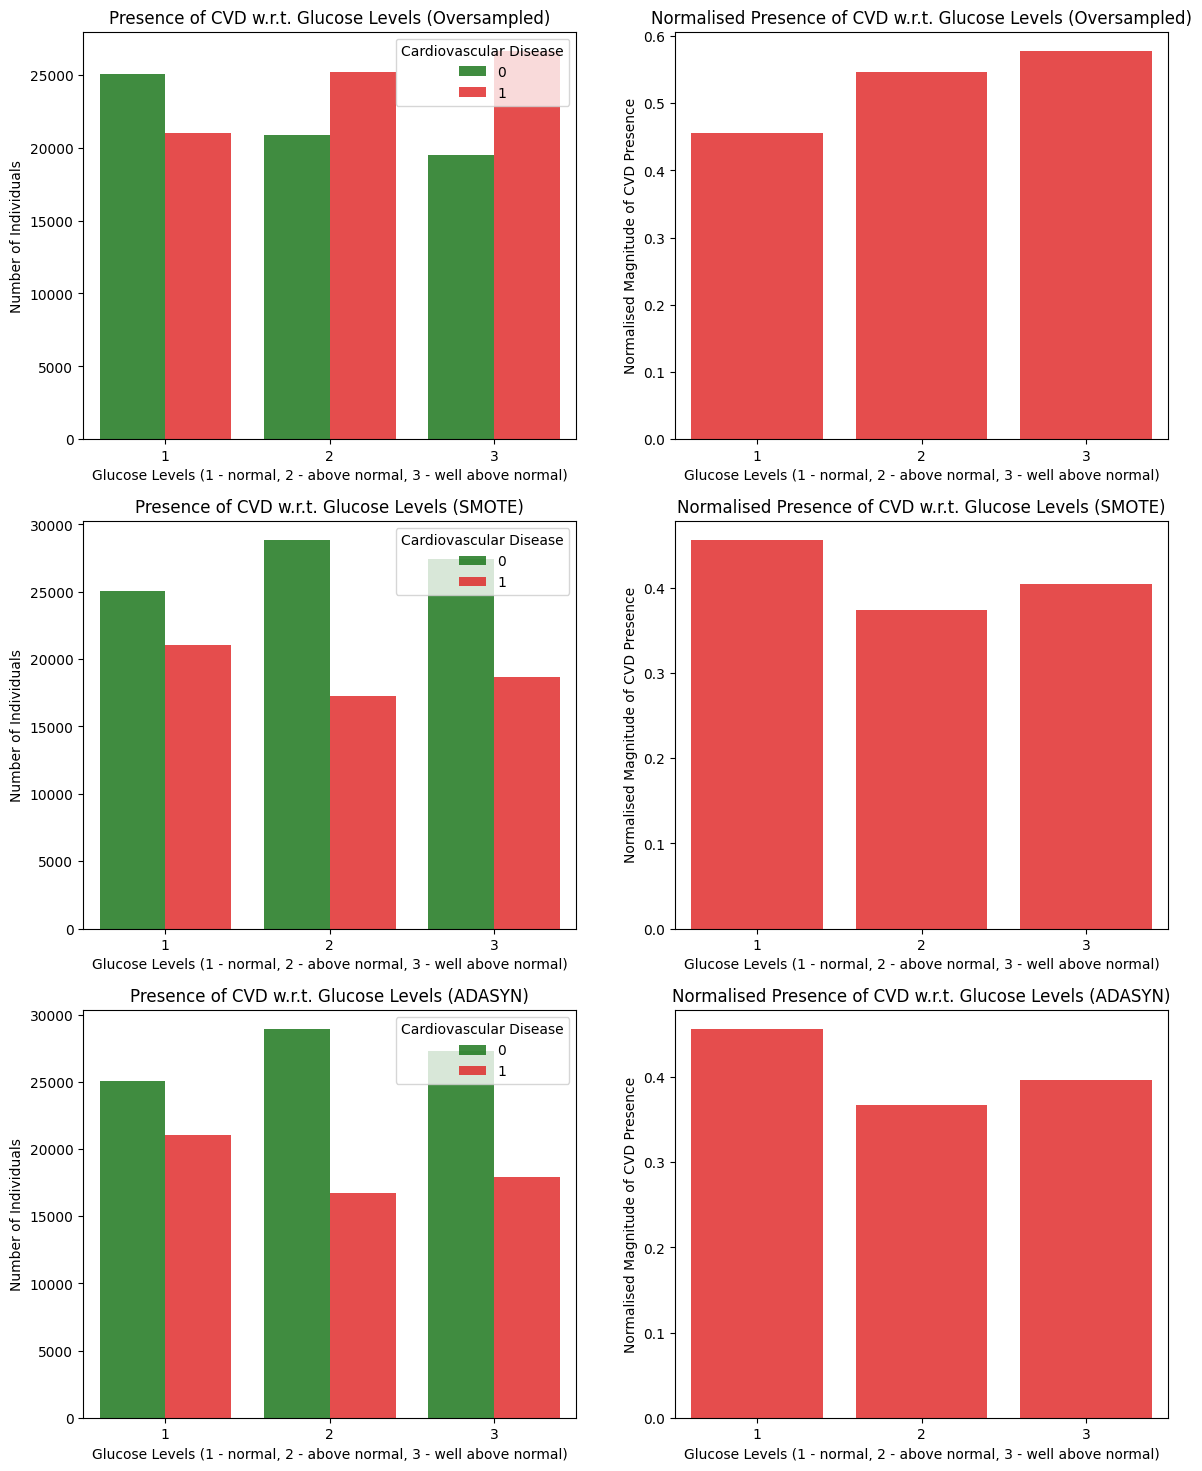

In [475]:
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# Grouping by 'gluc' and 'cardio' columns and calculating counts
grouped = df_gluc_resampled.groupby(['gluc', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='gluc', var_name='Cardiovascular Disease', value_name='Count')

gluc_res_cvd_bar = sns.barplot(data=melted, x='gluc', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0, 0])
gluc_res_cvd_bar.set_title("Presence of CVD w.r.t. Glucose Levels (Oversampled)")
gluc_res_cvd_bar.set_xlabel("Glucose Levels (1 - normal, 2 - above normal, 3 - well above normal)")
gluc_res_cvd_bar.set_ylabel("Number of Individuals")


# Calculate percentages
grouped_total = df_gluc_resampled.groupby('gluc').size().reset_index(name='Total')
grouped_cvd = df_gluc_resampled[df_gluc_resampled['cardio'] == 1].groupby('gluc').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='gluc')

# Calculate percentages
merged['Percentage_gluc'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
gluc_res_cvd_norm_bar = sns.barplot(data=merged, x='gluc', y='Percentage_gluc', color='red',  alpha=0.8, ax=axes[0, 1])
gluc_res_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Glucose Levels (Oversampled)")
gluc_res_cvd_norm_bar.set_xlabel("Glucose Levels (1 - normal, 2 - above normal, 3 - well above normal)")
gluc_res_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")








# Grouping by 'gluc' and 'cardio' columns and calculating counts
grouped = df_gluc_smote.groupby(['gluc', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='gluc', var_name='Cardiovascular Disease', value_name='Count')

gluc_res_cvd_bar = sns.barplot(data=melted, x='gluc', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[1, 0])
gluc_res_cvd_bar.set_title("Presence of CVD w.r.t. Glucose Levels (SMOTE)")
gluc_res_cvd_bar.set_xlabel("Glucose Levels (1 - normal, 2 - above normal, 3 - well above normal)")
gluc_res_cvd_bar.set_ylabel("Number of Individuals")


# Calculate percentages
grouped_total = df_gluc_smote.groupby('gluc').size().reset_index(name='Total')
grouped_cvd = df_gluc_smote[df_gluc_smote['cardio'] == 1].groupby('gluc').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='gluc')

# Calculate percentages
merged['Percentage_gluc'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
gluc_res_cvd_norm_bar = sns.barplot(data=merged, x='gluc', y='Percentage_gluc', color='red',  alpha=0.8, ax=axes[1, 1])
gluc_res_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Glucose Levels (SMOTE)")
gluc_res_cvd_norm_bar.set_xlabel("Glucose Levels (1 - normal, 2 - above normal, 3 - well above normal)")
gluc_res_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")






# Grouping by 'gluc' and 'cardio' columns and calculating counts
grouped = df_gluc_adasyn.groupby(['gluc', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='gluc', var_name='Cardiovascular Disease', value_name='Count')

gluc_res_cvd_bar = sns.barplot(data=melted, x='gluc', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[2, 0])
gluc_res_cvd_bar.set_title("Presence of CVD w.r.t. Glucose Levels (ADASYN)")
gluc_res_cvd_bar.set_xlabel("Glucose Levels (1 - normal, 2 - above normal, 3 - well above normal)")
gluc_res_cvd_bar.set_ylabel("Number of Individuals")


# Calculate percentages
grouped_total = df_gluc_adasyn.groupby('gluc').size().reset_index(name='Total')
grouped_cvd = df_gluc_adasyn[df_gluc_adasyn['cardio'] == 1].groupby('gluc').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='gluc')

# Calculate percentages
merged['Percentage_gluc'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
gluc_res_cvd_norm_bar = sns.barplot(data=merged, x='gluc', y='Percentage_gluc', color='red',  alpha=0.8, ax=axes[2, 1])
gluc_res_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Glucose Levels (ADASYN)")
gluc_res_cvd_norm_bar.set_xlabel("Glucose Levels (1 - normal, 2 - above normal, 3 - well above normal)")
gluc_res_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 7.4 - Activity data

### 7.4.1 - Oversample re-sampling

In [476]:
# create dataframes for majority and minority classes
df_active = df[df['active'] == 1]
df_inactive = df[df['active'] == 0]

# upsample minority class
df_inactive_upsampled = resample(
    df_inactive,
    replace=True,
    n_samples=len(df_active),
    random_state=42
)

# combine majority class with upsampled minority class
df_inactive_resampled = pd.concat([df_inactive_upsampled, df_active])

print(len(df_active), len(df_inactive_upsampled))

43561 43561


### 7.4.2 - SMOTE

In [477]:
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(random_state=42)

df_sm = df.copy()

# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(df_sm.drop('active', axis=1), df_sm['active'])
df_active_smote = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

### 7.4.3 - ADASYN

In [478]:
# Resampling the minority class. The strategy can be changed as required.
ada = ADASYN(sampling_strategy='minority', random_state=42)

df_ada = df.copy()

# Fit the model to generate the data.
oversampled_X, oversampled_Y = ada.fit_resample(df_ada.drop('active', axis=1), df_ada['active'])
df_active_adasyn = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

### 7.4.3 - Visualisation

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

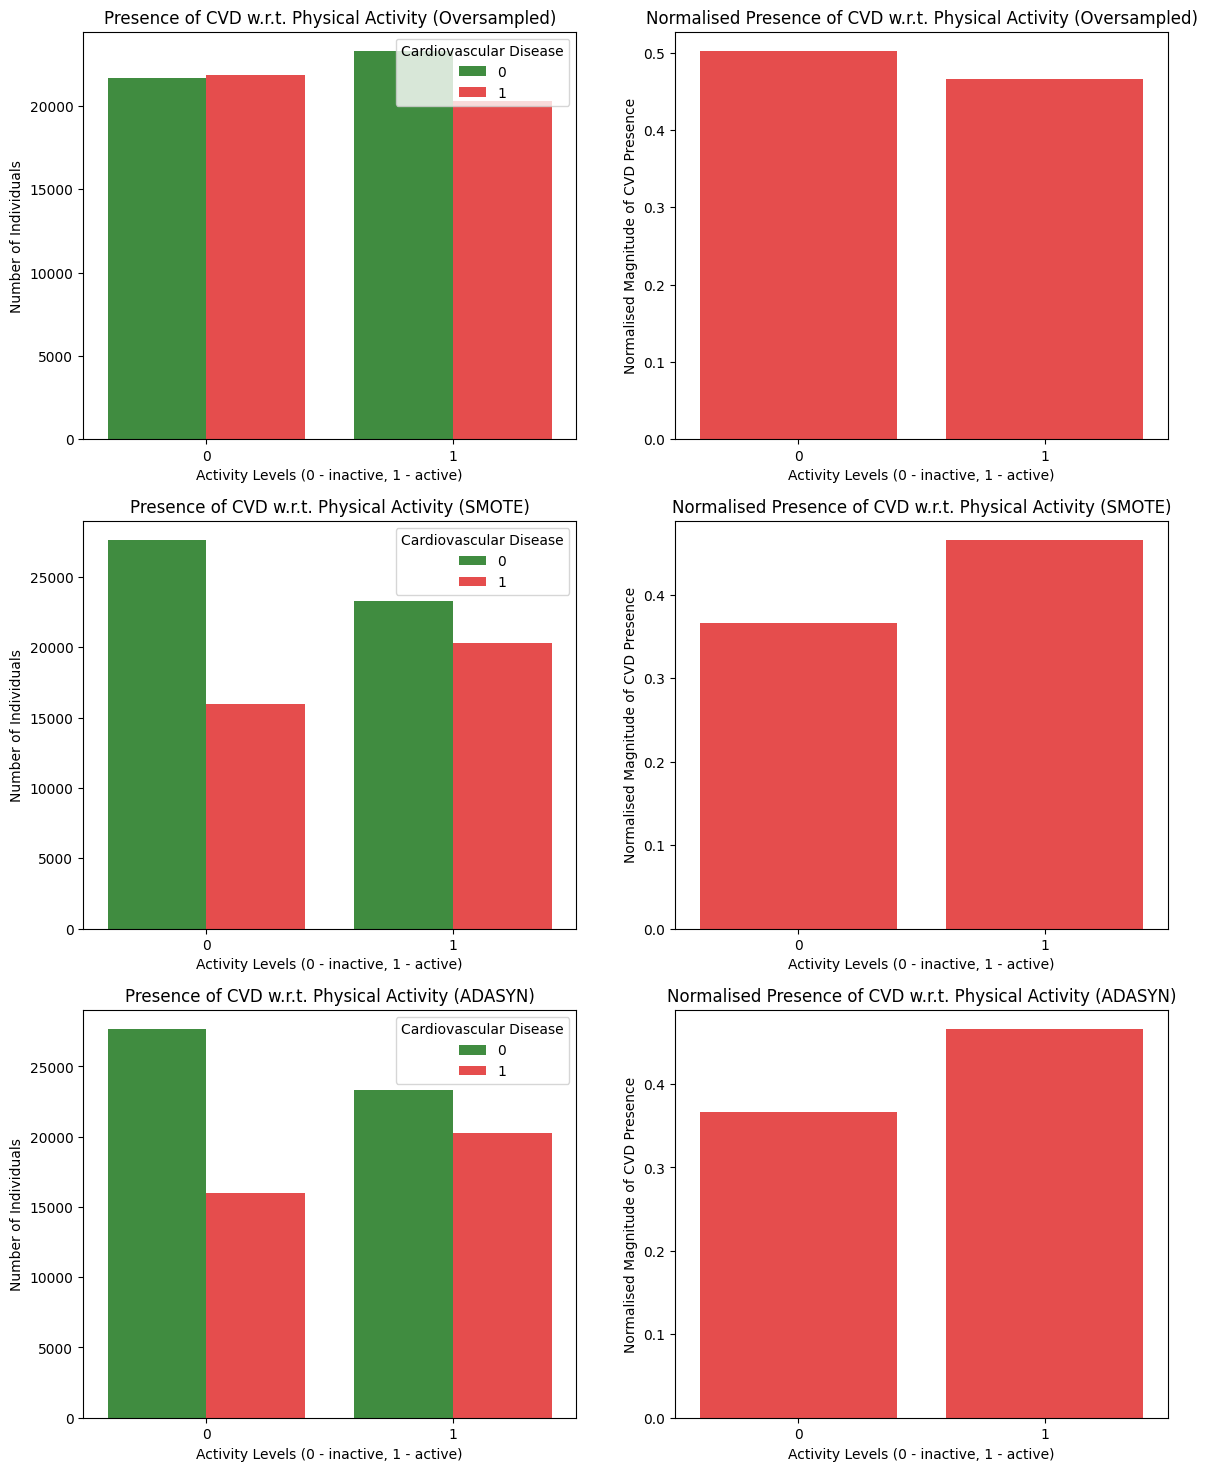

In [479]:
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# Grouping by 'active' and 'cardio' columns and calculating counts
grouped = df_inactive_resampled.groupby(['active', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='active', var_name='Cardiovascular Disease', value_name='Count')

# Plotting the grouped bar plot
inac_cvd_bar = sns.barplot(data=melted, x='active', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0, 0])
inac_cvd_bar.set_title("Presence of CVD w.r.t. Physical Activity (Oversampled)")
inac_cvd_bar.set_xlabel("Activity Levels (0 - inactive, 1 - active)")
inac_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df_inactive_resampled.groupby('active').size().reset_index(name='Total')
grouped_cvd = df_inactive_resampled[df_inactive_resampled['cardio'] == 1].groupby('active').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='active')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
inac_cvd_norm_bar = sns.barplot(data=merged, x='active', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[0, 1])
inac_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Physical Activity (Oversampled)")
inac_cvd_norm_bar.set_xlabel("Activity Levels (0 - inactive, 1 - active)")
inac_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")











# Grouping by 'active' and 'cardio' columns and calculating counts
grouped = df_active_smote.groupby(['active', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='active', var_name='Cardiovascular Disease', value_name='Count')

# Plotting the grouped bar plot
inac_cvd_bar = sns.barplot(data=melted, x='active', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[1, 0])
inac_cvd_bar.set_title("Presence of CVD w.r.t. Physical Activity (SMOTE)")
inac_cvd_bar.set_xlabel("Activity Levels (0 - inactive, 1 - active)")
inac_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df_active_smote.groupby('active').size().reset_index(name='Total')
grouped_cvd = df_active_smote[df_active_smote['cardio'] == 1].groupby('active').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='active')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
inac_cvd_norm_bar = sns.barplot(data=merged, x='active', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[1, 1])
inac_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Physical Activity (SMOTE)")
inac_cvd_norm_bar.set_xlabel("Activity Levels (0 - inactive, 1 - active)")
inac_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")








# Grouping by 'active' and 'cardio' columns and calculating counts
grouped = df_active_adasyn.groupby(['active', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='active', var_name='Cardiovascular Disease', value_name='Count')

# Plotting the grouped bar plot
inac_cvd_bar = sns.barplot(data=melted, x='active', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[2, 0])
inac_cvd_bar.set_title("Presence of CVD w.r.t. Physical Activity (ADASYN)")
inac_cvd_bar.set_xlabel("Activity Levels (0 - inactive, 1 - active)")
inac_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df_active_adasyn.groupby('active').size().reset_index(name='Total')
grouped_cvd = df_active_adasyn[df_active_adasyn['cardio'] == 1].groupby('active').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='active')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
inac_cvd_norm_bar = sns.barplot(data=merged, x='active', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[2, 1])
inac_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Physical Activity (ADASYN)")
inac_cvd_norm_bar.set_xlabel("Activity Levels (0 - inactive, 1 - active)")
inac_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 7.5 - Alcohol data

### 7.5.1 - Oversample re-sampling

In [480]:
# create dataframes for majority and minority classes
df_drinkers = df[df['alco'] == 1]
df_nondrinkers = df[df['alco'] == 0]

# upsample minority class
df_drinkers_upsampled = resample(
    df_drinkers,
    replace=True,
    n_samples=len(df_nondrinkers),
    random_state=42
)

# combine majority class with upsampled minority class
df_alco_resampled = pd.concat([df_drinkers_upsampled, df_nondrinkers])

print(len(df_nondrinkers), len(df_drinkers_upsampled))

51473 51473


### 7.5.2 - SMOTE

In [481]:
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(random_state=42)

df_sm = df.copy()

# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(df_sm.drop('alco', axis=1), df_sm['alco'])
df_alco_smote = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

### 7.5.3 - ADASYN

In [482]:
# Resampling the minority class. The strategy can be changed as required.
ada = ADASYN(sampling_strategy='minority', random_state=42)

df_ada = df.copy()

# Fit the model to generate the data.
oversampled_X, oversampled_Y = ada.fit_resample(df_ada.drop('alco', axis=1), df_ada['alco'])
df_alco_adasyn = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

### 7.5.3 - Visualisation

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

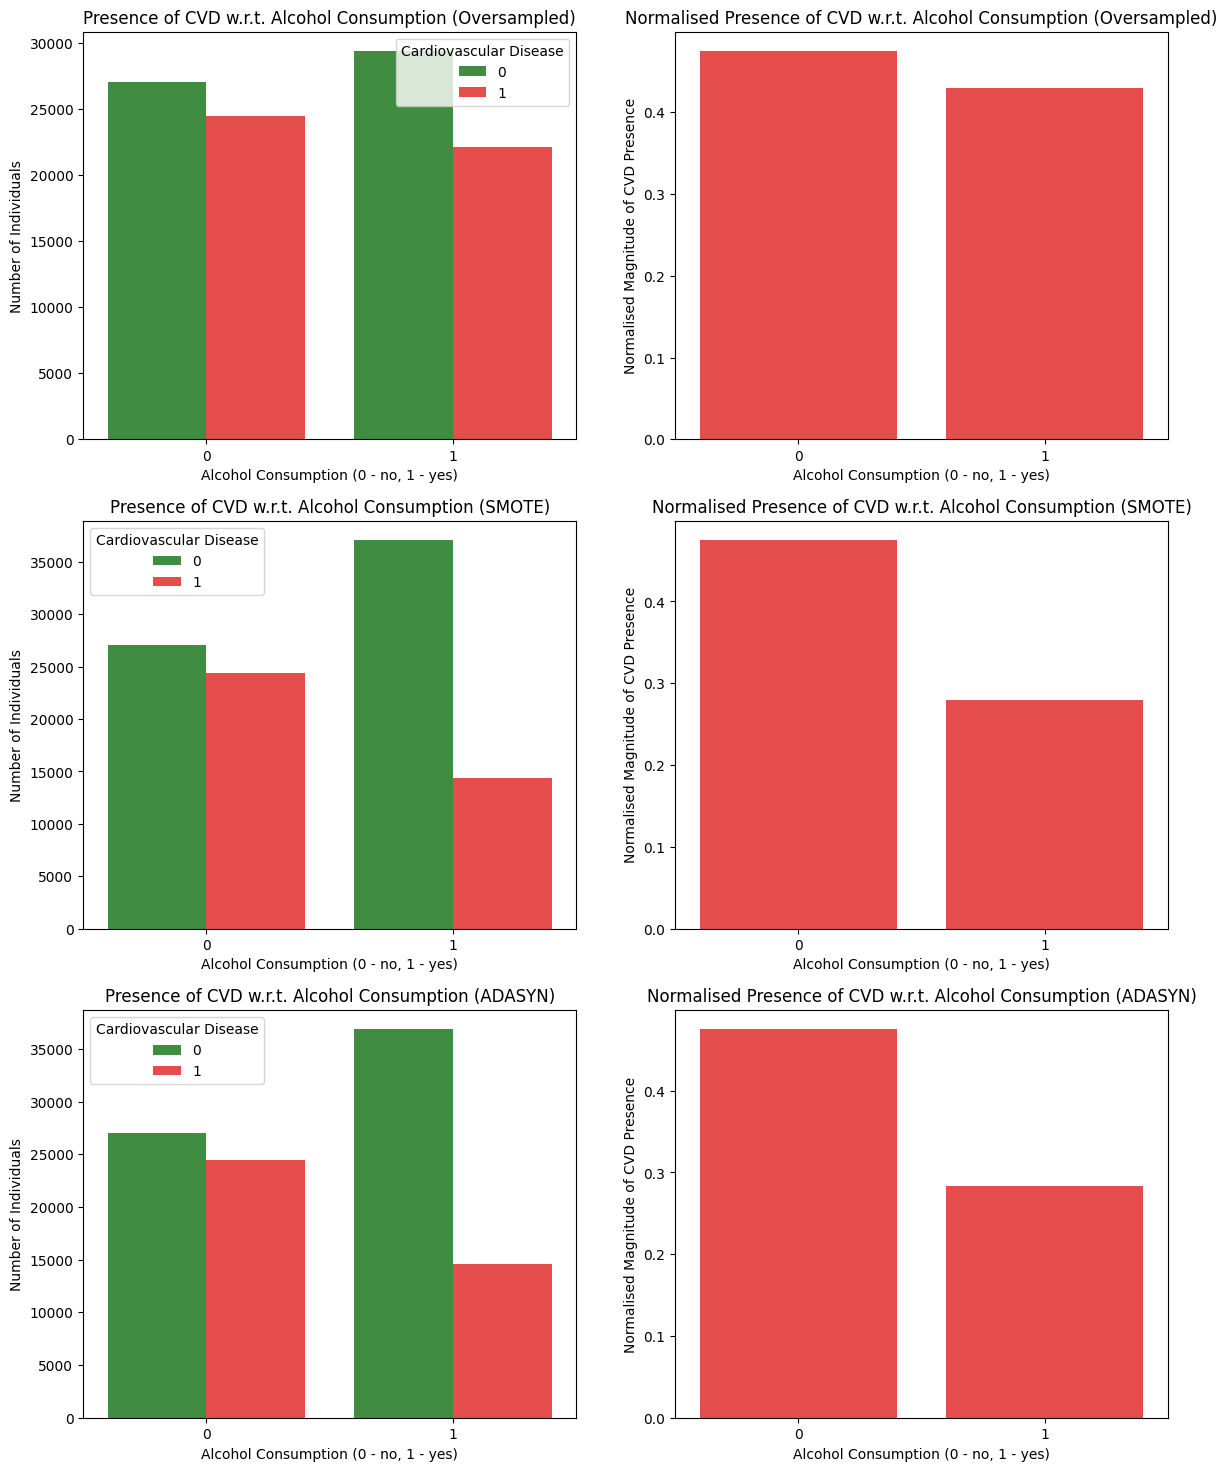

In [483]:
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# Grouping by 'alco' and 'cardio' columns and calculating counts
grouped = df_alco_resampled.groupby(['alco', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='alco', var_name='Cardiovascular Disease', value_name='Count')

# Plotting the grouped bar plot
alco_cvd_bar = sns.barplot(data=melted, x='alco', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0, 0])
alco_cvd_bar.set_title("Presence of CVD w.r.t. Alcohol Consumption (Oversampled)")
alco_cvd_bar.set_xlabel("Alcohol Consumption (0 - no, 1 - yes)")
alco_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df_alco_resampled.groupby('alco').size().reset_index(name='Total')
grouped_cvd = df_alco_resampled[df_alco_resampled['cardio'] == 1].groupby('alco').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='alco')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
alco_cvd_norm_bar = sns.barplot(data=merged, x='alco', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[0, 1])
alco_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Alcohol Consumption (Oversampled)")
alco_cvd_norm_bar.set_xlabel("Alcohol Consumption (0 - no, 1 - yes)")
alco_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")








# Grouping by 'alco' and 'cardio' columns and calculating counts
grouped = df_alco_smote.groupby(['alco', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='alco', var_name='Cardiovascular Disease', value_name='Count')

# Plotting the grouped bar plot
alco_cvd_bar = sns.barplot(data=melted, x='alco', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[1, 0])
alco_cvd_bar.set_title("Presence of CVD w.r.t. Alcohol Consumption (SMOTE)")
alco_cvd_bar.set_xlabel("Alcohol Consumption (0 - no, 1 - yes)")
alco_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df_alco_smote.groupby('alco').size().reset_index(name='Total')
grouped_cvd = df_alco_smote[df_alco_smote['cardio'] == 1].groupby('alco').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='alco')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
alco_cvd_norm_bar = sns.barplot(data=merged, x='alco', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[1, 1])
alco_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Alcohol Consumption (SMOTE)")
alco_cvd_norm_bar.set_xlabel("Alcohol Consumption (0 - no, 1 - yes)")
alco_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")








# Grouping by 'alco' and 'cardio' columns and calculating counts
grouped = df_alco_adasyn.groupby(['alco', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='alco', var_name='Cardiovascular Disease', value_name='Count')

# Plotting the grouped bar plot
alco_cvd_bar = sns.barplot(data=melted, x='alco', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[2, 0])
alco_cvd_bar.set_title("Presence of CVD w.r.t. Alcohol Consumption (ADASYN)")
alco_cvd_bar.set_xlabel("Alcohol Consumption (0 - no, 1 - yes)")
alco_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df_alco_adasyn.groupby('alco').size().reset_index(name='Total')
grouped_cvd = df_alco_adasyn[df_alco_adasyn['cardio'] == 1].groupby('alco').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='alco')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
alco_cvd_norm_bar = sns.barplot(data=merged, x='alco', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[2, 1])
alco_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Alcohol Consumption (ADASYN)")
alco_cvd_norm_bar.set_xlabel("Alcohol Consumption (0 - no, 1 - yes)")
alco_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

# 8 - Feature Extraction

Text(0.5, 1.0, 'Feature Correlation Heatmap')

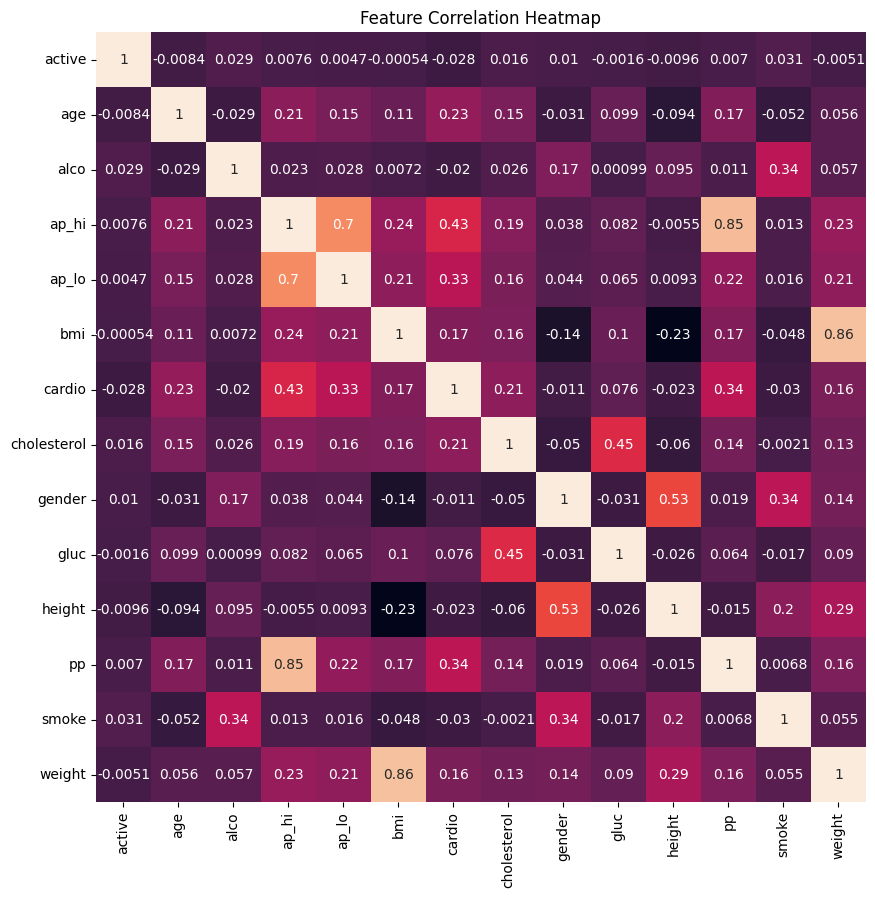

In [484]:
fig,axes = plt.subplots(figsize=(10,10))

data = df.select_dtypes(include=['float64','int64'])
data = data.reindex(sorted(data.columns), axis=1)

correlation = data.corr()
corr_heat = sns.heatmap(correlation,ax=axes,vmax=1,square=True, annot=True,cbar=False)

corr_heat.set_title("Feature Correlation Heatmap")

# 9 - Supervised Learning Methods

## 9.1 - Data preprocessing

In [485]:
X = df[['ap_hi', 'ap_lo', 'pp', 'age', 'cholesterol', 'bmi', 'weight']]
Y = df['cardio']

## 9.2 - Data splitting

Split the data into training and testing sets (80% training, 20% testing)

In [486]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## 9.3 - Build and train models

### 9.3.1 - Decision Tree Classifier

In [487]:
# Create a Decision Tree classifier
DTmodel = DecisionTreeClassifier(
    max_depth=3
)

# train model on training data
DTmodel.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=3)

### 9.3.2 - Random Forest Classifier

In [488]:
# Create a Random Forest classifier
RFmodel = RandomForestClassifier()

# Train model on training data
RFmodel.fit(X_train, Y_train)

RandomForestClassifier()

### 9.3.3 - Support Vector Classifier

In [489]:
# Create a Support Vector classifier
SVmodel = SVC()

# Train model
SVmodel.fit(X_train, Y_train)

SVC()

### 9.3.4 - K-Neighbours Classifier

In [490]:
# Create a KNeighbours classifier
KNmodel = KNeighborsClassifier()

# Train model
KNmodel.fit(X_train, Y_train)

KNeighborsClassifier()

### 9.3.5 - Multilayer Perceptron Classifier

In [491]:
# Create a Multilayer Perceptron classifier
MLPmodel = MLPClassifier(hidden_layer_sizes=(150,), activation='relu', solver='adam', max_iter=400)

# Train the model on the training data
MLPmodel.fit(X_train, Y_train)

MLPClassifier(hidden_layer_sizes=(150,), max_iter=400)

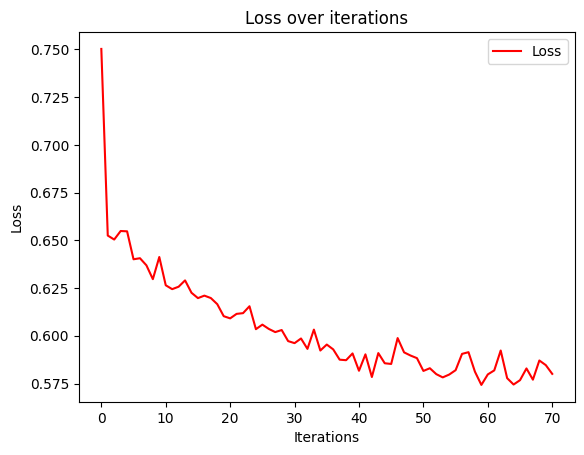

In [492]:
MLPloss = MLPmodel.loss_curve_
iter = [i for i in range(len(MLPloss))]
plt.plot(iter, MLPloss, color='red', label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.legend()
plt.show()

## 9.4 - Evaluate models

Make predictions on the testing data

In [493]:
Y_pred_DT = DTmodel.predict(X_test)

In [494]:
Y_pred_RF = RFmodel.predict(X_test)

In [495]:
Y_pred_SV = SVmodel.predict(X_test)

In [496]:
Y_pred_KN = KNmodel.predict(X_test)

In [497]:
Y_pred_MP = MLPmodel.predict(X_test)

## 9.5 - Estimate model accuracy

In [498]:
# Calculate and display the accuracy of the classifier
DTaccuracy = accuracy_score(Y_test, Y_pred_DT)
RFaccuracy = accuracy_score(Y_test, Y_pred_RF)
SVaccuracy = accuracy_score(Y_test, Y_pred_SV)
KNaccuracy = accuracy_score(Y_test, Y_pred_KN)
MPaccuracy = accuracy_score(Y_test, Y_pred_MP)

print("Decision Tree Accuracy:", DTaccuracy)
print("Random Forest Accuracy:", RFaccuracy)
print("Support Vector Accuracy:", SVaccuracy)
print("KNeighbors Accuracy:", KNaccuracy)
print("Multilayer Perceptron Accuracy:", MPaccuracy)

# Display the classification report
target_names = ['CVD Absent', 'CVD Present']

print("\nDT Classification Report:")
print(classification_report(Y_test, Y_pred_DT, target_names=target_names))
print("\nDT Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred_DT))

print("\nRF Classification Report:")
print(classification_report(Y_test, Y_pred_RF, target_names=target_names))
print("\nRF Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred_RF))

print("\nSVC Classification Report:")
print(classification_report(Y_test, Y_pred_SV, target_names=target_names))
print("\nSVC Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred_SV))

print("\nKNN Classification Report:")
print(classification_report(Y_test, Y_pred_KN, target_names=target_names))
print("\nKNN Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred_KN))

print("\nMLP Classification Report:")
print(classification_report(Y_test, Y_pred_MP, target_names=target_names))
print("\nMLP Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred_MP))

Decision Tree Accuracy: 0.7147571035747021
Random Forest Accuracy: 0.672410632447296
Support Vector Accuracy: 0.7120989917506875
KNeighbors Accuracy: 0.6750687442713107
Multilayer Perceptron Accuracy: 0.7122823098075161

DT Classification Report:
              precision    recall  f1-score   support

  CVD Absent       0.72      0.75      0.73      5709
 CVD Present       0.71      0.68      0.69      5201

    accuracy                           0.71     10910
   macro avg       0.71      0.71      0.71     10910
weighted avg       0.71      0.71      0.71     10910


DT Confusion Matrix:
[[4259 1450]
 [1662 3539]]

RF Classification Report:
              precision    recall  f1-score   support

  CVD Absent       0.69      0.69      0.69      5709
 CVD Present       0.66      0.65      0.66      5201

    accuracy                           0.67     10910
   macro avg       0.67      0.67      0.67     10910
weighted avg       0.67      0.67      0.67     10910


RF Confusion Matrix:
[